# AML3104 - Neural Networks and Deep Learning
# Final Project
# Group Zero Budget

Team members:
- Aanal Patel - ID: 910376
- Danilo Diaz - ID: 889539
- Ernie Sumoso - ID: 881591
- Jay Saravanan - ID: 910392
- Yogita Sharma - ID: 913011

## Table of Contents <a class="anchor" id="toc"></a>
* [Intro. Importing Libraries](#intro)
* [Part I. Data Gathering](#part-1)
* [Part IIa. Data Pipelines (OBJ to NPY)](#part-2a)
* [Part IIb. Data Pipelines (Generating Images in PNG format)](#part-2b)
* [Part IIc. Data Pipelines (PNG to NPY)](#part-2c)
* [Part III. ](#part-3)
* [Part IV. Compiling and Training a CNN](#part-4)
* [Part V. Validating Model](#part-5)

### Intro. Importing Libraries <a class="anchor" id="intro"></a>

In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import trimesh
import glob
import os

In [2]:
def get_category_names(data_path):

    # Initialize an empty array and loop through the folders within data path
    category_names = []
    for folder in os.scandir(data_path):

        # if the folder name starts with a number then it's a category name
        folder_basename = os.path.basename(folder.path)
        if folder.is_dir() and folder_basename[0].isdigit():
            category_names.append(folder_basename)
    return category_names

categories = get_category_names(r"D:\_Projects\ShapeNetCore")
print(f"We have {len(categories)} categories.")

We have 54 categories.


### Part IIa. Data Pipelines (OBJ to NPY) <a class="anchor" id="part-2a"></a>

In [4]:
def get_obj_files(data_path, recursive=True):
    
    # Retrieve OBJ files from the data path
    obj_files = [file for file in glob.glob(data_path + r"\**\*.obj", recursive=recursive)]
    print(f"Found {len(obj_files)} OBJ files.")
    return obj_files

def save_npy_array_from_obj(obj_files, voxel_shape, voxel_resolution=0.025, save_npy=True, npy_filename='voxel_grids'):
    
    # Loop through the OBJ files and initialize an empty array that will contain np arrays
    print("Starting the pipeline...")
    np_arrays = []
    for i, obj_file in enumerate(obj_files):
    
        # Read the mesh from the OBJ file
        mesh = trimesh.load(obj_file, force='mesh')
        
        # Create a voxel grid
        voxelized = mesh.voxelized(pitch=voxel_resolution)
        voxelized = voxelized.revoxelized(shape=voxel_shape)
        voxel_matrix = voxelized.matrix
        
        # Reshape the array to (voxel_shape, 1)
        new_shape = tuple(list(voxel_shape) + [1])
        voxel_matrix = voxel_matrix.reshape(new_shape)
        np_arrays.append(voxel_matrix)
        print(f"{i+1}", end=" ")
    
    # Save the voxel matrix as an NPY file
    np_arrays_stacked = np.stack(tuple(np_arrays), axis=0)
    print(f"Final NumPy array shape: {np_arrays_stacked.shape}")

    # Save the NumPy array as an NPY file if specified, otherwise, return the array
    if save_npy:
        np.save(npy_filename + ".npy", np_arrays_stacked)
        return None
    return np_arrays_stacked

# Save the paths of each of the OBJ files into a list
DATA_PATH = r"D:\_Projects\ShapeNetCore\02691156"
obj_files = get_obj_files(DATA_PATH)

Found 4045 OBJ files.


In [5]:
# Convert OBJ files into voxel grids, and save them into a Numpy array
save_npy_array_from_obj(obj_files, (32, 32, 32), voxel_resolution=0.025)

Starting the pipeline...
1 2 3 


KeyboardInterrupt



In [ ]:
def save_npy_array_from_obj_per_category(data_path, voxel_shape, voxel_resolution=0.025):

    # Get the category names (55)
    categories = get_category_names(data_path)
    print(f"Found {len(categories)} categories.")

    # Loop through the categories
    for i, category in enumerate(categories):
        print(f"================ Starting process for category #{i+1}, name: {category} ================")

        # Set the category data path and retrieve all obj files
        category_path = data_path + '\\' + category
        obj_files = get_obj_files(category_path, recursive=True)
        
        # Convert OBJ files into voxel grids, and save them into a Numpy array
        save_npy_array_from_obj(obj_files, voxel_shape, voxel_resolution, save_npy=True, npy_filename=category+"_voxels")

data_path = r"D:\_Projects\ShapeNetCore"
save_npy_array_from_obj_per_category(data_path, (32, 32, 32))

### Part IIb. Data Pipelines (Generating images in PNG format) <a class="anchor" id="part-2b"></a>

In [ ]:
def render_images_from_obj_files(obj_files, renderer_git_path, n_views, output_path, randomize_view, start_id=0):
    
    # Save current path and change to the stanford-shapenet-renderer tool path
    current_path = os.getcwd()
    os.chdir(renderer_git_path)
    
    # For each OBJ file, generate the images using the renderer tool
    print("Starting the pipeline (generating images)...")
    for i, obj_file in enumerate(obj_files):
        print(f"{i+1}", end=" ")
        command_str = f'blender --background --python render_blender.py -- --views {n_views} --id_render {start_id+i+1} --randomize_view {int(randomize_view)} --output_folder {output_path} {obj_file}'
        os_return = os.system(command_str)
        
        # Check if process was executed succesfully
        if os_return != 0:
            print(f"Error... os returned: {os_return}")
            break
            
    # Return to the original path
    os.chdir(current_path)

def render_images_per_category(categories, n_views, renderer_path, data_path, output_path, randomize_view=False):
    print(f"Found {len(categories)} categories.")
    
    # Loop through each of the categories
    for i, category in enumerate(categories):
        print(f"\n================ Starting process for category #{i+1}, name: {category} ================")

        # Set the category data path and retrieve all obj files
        category_path = data_path + '\\' + category
        obj_files = get_obj_files(category_path, recursive=True)
        
        # Render the images according to the parameters
        render_images_from_obj_files(obj_files, renderer_path, n_views, output_path + "/" + category, randomize_view)

data_path = r"D:\_Projects\ShapeNetCore"
renderer_path = r"D:\_Projects\stanford-shapenet-renderer"
output_path = "/_Projects/ShapeNetCore-Images"
render_images_per_category(categories, 10, renderer_path, data_path, output_path, randomize_view=False)

### Part IIc. Data Pipelines (PNG to NPY) <a class="anchor" id="part-2c"></a>

In [3]:
def get_png_files(data_path, recursive=True):
    
    # Retrieve PNG files from the data path
    png_files = [file for file in glob.glob(data_path + r"\**\*.png", recursive=recursive)]
    print(f"Found {len(png_files)} PNG files.")
    return png_files

def save_npy_array_from_png(png_files, image_shape, save_npy=True, npy_filename='images'):
    
    # Loop through the PNG files and initialize an empty array that will contain np arrays
    print("Starting pipeline...")
    np_arrays = []
    curr_progress, prev_progress = 0.0, -0.5
    for i, png_file in enumerate(png_files):

        # Open the image and convert into grayscale
        img = Image.open(png_file)
        img_gray = img.convert("L")
        
        # Resize the image to the desired shape and into a numpy array
        img_resized = img_gray.resize(image_shape)
        img_array = np.array(img_resized)
        
        # Reshape the array to (image shape, 1)
        new_shape = tuple(list(image_shape) + [1])
        img_array = img_array.reshape(new_shape)
        np_arrays.append(img_array)
        
        # Print progress, but not on every loop
        curr_progress = round(100 * (i+1) / len(png_files), 2)
        if (curr_progress - prev_progress) >= 0.5:
            prev_progress = float(curr_progress)
            print(f"{curr_progress}%", end=" ")
            if curr_progress != 0.0 and curr_progress % 10.0 == 0:
                print(f"({i+1} files done)")
    
    # Save the voxel matrix as an NPY file
    np_arrays_stacked = np.stack(tuple(np_arrays), axis=0)
    print(f"\nFinal NumPy array shape: {np_arrays_stacked.shape}")
    
    # Save the NumPy array as an NPY file if specified, otherwise, return the array
    if save_npy:
        np.save(npy_filename + ".npy", np_arrays_stacked)
        return None
    return np_arrays_stacked

def save_npy_array_from_png_per_category(data_path, image_shape):
    
    # Get the category names
    categories = get_category_names(data_path)
    print(f"Found {len(categories)} categories.")

    # Loop through the categories
    for i, category in enumerate(categories[1:]):
        print(f"================ Starting process for category #{i+1}, name: {category} ================")

        # Set the category data path and retrieve all images in PNG format
        category_path = data_path + '\\' + category
        png_files = get_png_files(category_path, recursive=True)
        
        # Fixing the image files order due to naming error during generation, now files are in proper id order
        png_files = list(sorted(png_files, key=lambda x: int(x.split('\\')[-1].split('_')[2])))

        # Convert PNG files into Numpy arrays
        save_npy_array_from_png(png_files, image_shape, save_npy=True, npy_filename=category+"_images")

# Read all images, convert them into a proper format, and save them into a Numpy array
data_path = r"D:\_Projects\ShapeNetCore-Images"
# save_npy_array_from_png_per_category(data_path, (128, 128))

In [ ]:
# Read all images, convert them into a proper format, and save them into a Numpy array
save_npy_array_from_png(png_files, (128, 128))

### Part IV. Compiling and Training a CNN <a class="anchor" id="#part-4"></a>

In [83]:
from tensorflow.keras import layers, models

def build_cnn_model_v0(input_shape, output_shape):
    
    # Building CNN: encoder (2D Convolutions to process 2D images)
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    # Add a flatten and dense layers to create bottleneck (latent) representation
    model.add(layers.Flatten())
    model.add(layers.Dense(4 * 4 * 4 * 64, activation='relu'))

    # Reshape to 3D for the decoder
    model.add(layers.Reshape((4, 4, 4, 64)))
    
    # Decoder (3D Convolutions to generate voxel grid)
    model.add(layers.Conv3DTranspose(64, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Conv3DTranspose(32, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Conv3DTranspose(16, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same'))  # Sigmoid for binary voxel grid

    return model

def build_cnn_model_v1(input_shape, output_shape):
    model = models.Sequential()

    # Encoder (2D Convolutions)
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    # Latent Space
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))  # Smaller bottleneck layer
    model.add(layers.Dropout(0.3))  # Prevent overfitting
    model.add(layers.Dense(4 * 4 * 4 * 64, activation='relu'))
    model.add(layers.Reshape((4, 4, 4, 64)))
    
    # Decoder (3D Convolutions)
    model.add(layers.Conv3DTranspose(64, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv3DTranspose(32, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv3DTranspose(16, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same'))
    
    return model

def build_cnn_model_v2(input_shape, output_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.25))
    
    # Add a flatten and dense layers to create bottleneck (latent) representation
    model.add(layers.Flatten())
    model.add(layers.Dense(4 * 4 * 4 * 64, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Reshape to 3D for the decoder
    model.add(layers.Reshape((4, 4, 4, 64)))
    
    # Decoder (3D Convolutions to generate voxel grid)
    model.add(layers.Conv3DTranspose(64, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv3DTranspose(32, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv3DTranspose(16, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same'))  # Sigmoid for binary voxel grid

    return model

In [5]:
def prepare_data_based_on_images_per_voxel(images_npy, voxels_npy, images_per_voxel):

    if images_per_voxel < 1 or images_per_voxel > 10:
        raise Exception("images_per_voxel should be a positive integer <= 10")

    # Data augmentation on the 3D voxels data if required (due to more image data)
    if images_per_voxel != 1:
        voxels_npy = np.repeat(voxels_npy, repeats=images_per_voxel, axis=0)

    if images_per_voxel == 10:
        return images_npy, voxels_npy
    
    # Data segmentation on the images data if required (due to less voxel data)
    chunk_size = 10
    num_chunks = images_npy.shape[0] // chunk_size
    
    # Initialize empty list of selected images
    selected_images = []
    
    # Loop over each chunk and get start and end of current chunk
    for i in range(num_chunks):
        chunk_start = i * chunk_size
        chunk_end = (i + 1) * chunk_size
        
        # Get the indices for equally spaced elements within this chunk, appending the result
        indices = np.linspace(chunk_start, chunk_end - 1, images_per_voxel, dtype=int)
        selected_images.append(images_npy[indices])
    
    # Convert the result list to a NumPy
    images_npy = np.concatenate(selected_images, axis=0)
    
    return images_npy, voxels_npy

In [8]:
from sklearn.model_selection import train_test_split

def split_data(category, input_shape, output_shape, images_per_voxel, test_size):
    # Set strings with the input and output reso for file reading
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])
    
    # Load the numpy arrays (input and output)
    images = np.load(f'images/{input_reso}/{category}_images.npy')
    voxels = np.load(f'voxels/{output_reso}/{category}_voxels.npy')

    # Prepare data based on required images per 3D object
    images, voxels = prepare_data_based_on_images_per_voxel(images, voxels, images_per_voxel)

    # Split into test and train subsets
    x_train, x_test, y_train, y_test = train_test_split(images, voxels, test_size=test_size)

    #TODO: DELETE THIS CODE, JUST TESTING
    perc = 1
    l_train, l_test = len(x_train), len(x_test)
    s_train, s_test = int(l_train * perc), int(l_test * perc)
    x_train, x_test, y_train, y_test = x_train[:s_train], x_test[:s_test], y_train[:s_train], y_test[:s_test]
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_data('02747177', input_shape=(128, 128, 1), output_shape=(32, 32, 32, 1), images_per_voxel=10, test_size=0.3)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2401, 128, 128, 1),
 (1029, 128, 128, 1),
 (2401, 32, 32, 32, 1),
 (1029, 32, 32, 32, 1))

In [115]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

def train_model_one_category(category, x_train, x_test, y_train, y_test, input_shape, output_shape, images_per_voxel, validation_split):
    # Set strings with the input and output reso for file reading
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])
    
    # Instantiate and compile the model
    # with tf.device('/CPU:0'):
    model = build_cnn_model(input_shape, output_shape)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])        
    
    # Early Stopping
    es = EarlyStopping(monitor='val_loss',
                       mode='min',
                       verbose=1,
                       patience=10,
                       restore_best_weights=True)

    # Model Checkpoint
    mc = ModelCheckpoint(filepath=f'models/{images_per_voxel}x{input_reso}x{output_reso}/{category}.keras',
                         monitor='val_accuracy',
                         mode='max',
                         verbose=1,
                         save_best_only=True,
                         )

    # Train Model
    model_history = model.fit(x_train,
                            y_train,
                            epochs=100,
                            batch_size=32,
                            validation_split=validation_split,
                            verbose=1,
                            callbacks=[es, mc])
    return model, model_history

# model_history = train_model_one_category('02747177', x_train, x_test, y_train, y_test, input_shape=(128, 128, 1), output_shape=(32, 32, 32, 1), validation_split=0.2)

In [92]:
from keras.models import load_model
# tf.config.list_physical_devices()
# with tf.device('/CPU:0'):

def evaluate_best_model(category, x_test, y_test, input_shape, output_shape, images_per_voxel, run_on_gpu=True):
    run_on = 'G' if run_on_gpu else 'C'
        
    # Run on CPU or GPU depending on param
    with tf.device(f'/{run_on}PU:0'):
    
        # Set strings with the input and output reso for file reading
        input_reso = str(input_shape[0])
        output_reso = str(output_shape[0])
        print(f'Evaluating best model on category {category}, input: {input_reso}, output: {output_reso}.')
        
        # Load the best model from training
        model = load_model(f'models/{images_per_voxel}x{input_reso}x{output_reso}/{category}.keras')
        
        # Evaluate best model with test data
        loss, accuracy = model.evaluate(x_test, y_test)
        print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

    return loss, accuracy

# loss, accuracy = evaluate_best_model('02747177', x_test, y_test, input_shape=(128, 128, 1), output_shape=(32, 32, 32, 1), run_on_gpu=False)

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_performance(category, i, input_shape, output_shape, images_per_voxel, model_history):

    # Set strings with the input and output reso and title
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])
    title = f'Category {category} (#{str(i+1)}/{len(categories)}): Model Performance'
    
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Train_Loss', 'Validation_Loss'], loc='upper left')
    plt.savefig(f'plots/{images_per_voxel}x{input_reso}x{output_reso}/{category}.png')
    plt.show()

# plot_model_performance('02747177', input_shape=(128, 128, 1), output_shape=(32, 32, 32, 1), model_history=model_history)

In [94]:
from keras.backend import clear_session
import gc

clear_session()
# del x_train, x_test, y_train, y_test, model_history
gc.collect()

5221

In [95]:
import pickle 

def save_dictionary_as_pickle(initial_path, filename, dictionary):
    # Save dictionary
    with open(initial_path + filename, 'wb+') as f:
        pickle.dump(dictionary, f)

Starting training model for category #1/5: 02691156
x_train shape: (32360, 128, 128, 1)
x_test shape: (8090, 128, 128, 1)
y_train shape: (32360, 32, 32, 32, 1)
y_test shape: (8090, 32, 32, 32, 1)
Epoch 1/100
809/809 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9285
Epoch 1: val_accuracy improved from -inf to 0.93519, saving model to models/128x32\02691156.keras
809/809 [==============================] - 117s 140ms/step - loss: 0.1656 - accuracy: 0.9285 - val_loss: 0.1511 - val_accuracy: 0.9352
Epoch 2/100
809/809 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9380
Epoch 2: val_accuracy improved from 0.93519 to 0.93658, saving model to models/128x32\02691156.keras
809/809 [==============================] - 114s 140ms/step - loss: 0.1413 - accuracy: 0.9380 - val_loss: 0.1464 - val_accuracy: 0.9366
Epoch 3/100
809/809 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9429
Epoch 3: val_accuracy improved from 0.93658 

INFO:tensorflow:Assets written to: ram://ff572569-78d8-4510-9058-5b58df7ce8af/assets


INFO:tensorflow:Assets written to: ram://ff572569-78d8-4510-9058-5b58df7ce8af/assets


Evaluating best model on category 02691156, input: 128, output: 32.
253/253 [==============================] - 121s 478ms/step - loss: 0.1463 - accuracy: 0.9377
Test Loss: 0.14631593227386475, Test Accuracy: 0.9377409815788269


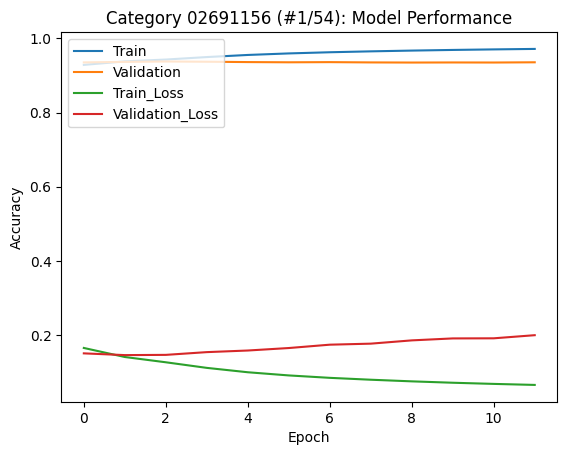

Starting training model for category #2/5: 02747177
x_train shape: (2744, 128, 128, 1)
x_test shape: (686, 128, 128, 1)
y_train shape: (2744, 32, 32, 32, 1)
y_test shape: (686, 32, 32, 32, 1)
Epoch 1/100
69/69 [==============================] - ETA: 0s - loss: 0.5229 - accuracy: 0.7294
Epoch 1: val_accuracy improved from -inf to 0.75026, saving model to models/128x32\02747177.keras
69/69 [==============================] - 30s 434ms/step - loss: 0.5229 - accuracy: 0.7294 - val_loss: 0.4559 - val_accuracy: 0.7503
Epoch 2/100
69/69 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.7628
Epoch 2: val_accuracy improved from 0.75026 to 0.79765, saving model to models/128x32\02747177.keras
69/69 [==============================] - 29s 421ms/step - loss: 0.4290 - accuracy: 0.7628 - val_loss: 0.4042 - val_accuracy: 0.7976
Epoch 3/100
69/69 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.8179
Epoch 3: val_accuracy improved from 0.79765 to 0.82246, savi

INFO:tensorflow:Assets written to: ram://30fac649-5509-4711-a198-37f6b1763a3c/assets


INFO:tensorflow:Assets written to: ram://30fac649-5509-4711-a198-37f6b1763a3c/assets


Evaluating best model on category 02747177, input: 128, output: 32.
22/22 [==============================] - 10s 459ms/step - loss: 0.3758 - accuracy: 0.8901
Test Loss: 0.37582001090049744, Test Accuracy: 0.8901155591011047


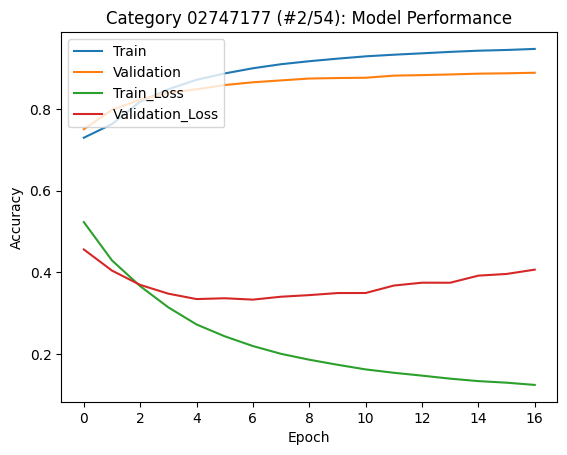

Starting training model for category #3/5: 02773838
x_train shape: (664, 128, 128, 1)
x_test shape: (166, 128, 128, 1)
y_train shape: (664, 32, 32, 32, 1)
y_test shape: (166, 32, 32, 32, 1)
Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.7005
Epoch 1: val_accuracy improved from -inf to 0.74924, saving model to models/128x32\02773838.keras
17/17 [==============================] - 22s 1s/step - loss: 0.6556 - accuracy: 0.7005 - val_loss: 0.5643 - val_accuracy: 0.7492
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 0.5408 - accuracy: 0.7498
Epoch 2: val_accuracy improved from 0.74924 to 0.75377, saving model to models/128x32\02773838.keras
17/17 [==============================] - 21s 1s/step - loss: 0.5408 - accuracy: 0.7498 - val_loss: 0.5121 - val_accuracy: 0.7538
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 0.5052 - accuracy: 0.7506
Epoch 3: val_accuracy improved from 0.75377 to 0.75380, saving model

INFO:tensorflow:Assets written to: ram://2ae50ca3-f015-4426-9410-a0375674ca01/assets


INFO:tensorflow:Assets written to: ram://2ae50ca3-f015-4426-9410-a0375674ca01/assets


Evaluating best model on category 02773838, input: 128, output: 32.
6/6 [==============================] - 3s 443ms/step - loss: 0.6145 - accuracy: 0.7933
Test Loss: 0.6144761443138123, Test Accuracy: 0.7932652831077576


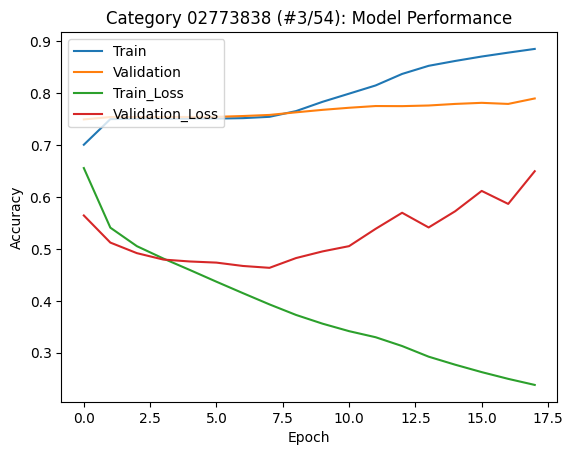

Starting training model for category #4/5: 02801938
x_train shape: (904, 128, 128, 1)
x_test shape: (226, 128, 128, 1)
y_train shape: (904, 32, 32, 32, 1)
y_test shape: (226, 32, 32, 32, 1)
Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 0.5476 - accuracy: 0.7423
Epoch 1: val_accuracy improved from -inf to 0.76618, saving model to models/128x32\02801938.keras
23/23 [==============================] - 23s 1s/step - loss: 0.5476 - accuracy: 0.7423 - val_loss: 0.4895 - val_accuracy: 0.7662
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: 0.4655 - accuracy: 0.7582
Epoch 2: val_accuracy improved from 0.76618 to 0.76628, saving model to models/128x32\02801938.keras
23/23 [==============================] - 23s 1s/step - loss: 0.4655 - accuracy: 0.7582 - val_loss: 0.4332 - val_accuracy: 0.7663
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 0.4171 - accuracy: 0.7592
Epoch 3: val_accuracy improved from 0.76628 to 0.77062, saving model

INFO:tensorflow:Assets written to: ram://0d828410-cab0-4f64-9ba7-c829ea7938a3/assets


INFO:tensorflow:Assets written to: ram://0d828410-cab0-4f64-9ba7-c829ea7938a3/assets


Evaluating best model on category 02801938, input: 128, output: 32.
8/8 [==============================] - 4s 422ms/step - loss: 0.5071 - accuracy: 0.8802
Test Loss: 0.5070503950119019, Test Accuracy: 0.8802471160888672


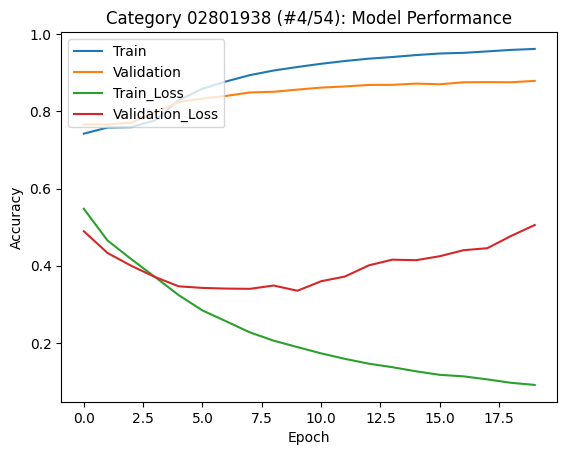

Starting training model for category #5/5: 02808440
x_train shape: (6848, 128, 128, 1)
x_test shape: (1712, 128, 128, 1)
y_train shape: (6848, 32, 32, 32, 1)
y_test shape: (1712, 32, 32, 32, 1)
Epoch 1/100
172/172 [==============================] - ETA: 0s - loss: 0.5163 - accuracy: 0.7266
Epoch 1: val_accuracy improved from -inf to 0.75572, saving model to models/128x32\02808440.keras
172/172 [==============================] - 55s 316ms/step - loss: 0.5163 - accuracy: 0.7266 - val_loss: 0.4767 - val_accuracy: 0.7557
Epoch 2/100
172/172 [==============================] - ETA: 0s - loss: 0.4523 - accuracy: 0.7689
Epoch 2: val_accuracy improved from 0.75572 to 0.77538, saving model to models/128x32\02808440.keras
172/172 [==============================] - 44s 257ms/step - loss: 0.4523 - accuracy: 0.7689 - val_loss: 0.4461 - val_accuracy: 0.7754
Epoch 3/100
172/172 [==============================] - ETA: 0s - loss: 0.4152 - accuracy: 0.7905
Epoch 3: val_accuracy improved from 0.77538 to 0

INFO:tensorflow:Assets written to: ram://1de4cdd5-272a-4a13-9b7e-a10a91ad195c/assets


INFO:tensorflow:Assets written to: ram://1de4cdd5-272a-4a13-9b7e-a10a91ad195c/assets


Evaluating best model on category 02808440, input: 128, output: 32.
54/54 [==============================] - 26s 477ms/step - loss: 0.4326 - accuracy: 0.7871
Test Loss: 0.43264785408973694, Test Accuracy: 0.7871068716049194


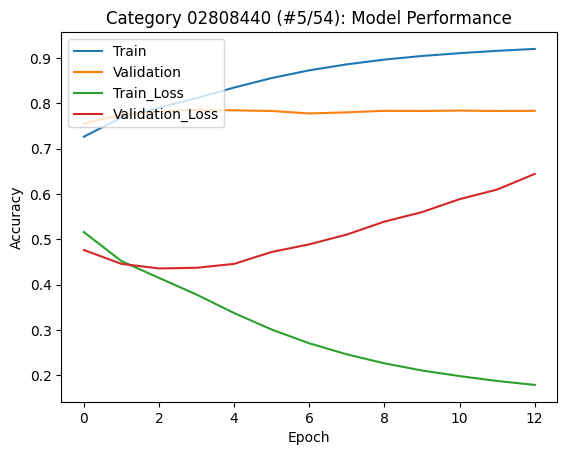

In [11]:
from keras.backend import clear_session
import gc

def train_models_all_categories(categories, input_shape, output_shape, images_per_voxel, test_size, validation_split):
    
    # Set strings with the input and output reso and title
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])

    # Empty dictionary that will contain all metrics
    metric_values = {}
    
    for i, category in enumerate(categories):
        print(f'Starting training model for category #{str(i+1)}/{len(categories)}: {category}')

        # Load and Split the data
        x_train, x_test, y_train, y_test = split_data(category, input_shape, output_shape, images_per_voxel, test_size)

        # Print subsets shape
        print(f'x_train shape: {x_train.shape}\nx_test shape: {x_test.shape}\ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')
        
        # Train model
        model_history = train_model_one_category(category, x_train, x_test, y_train, y_test, input_shape, output_shape, validation_split)

        # Save model history dictionary as pickle file
        save_dictionary_as_pickle(f'history/{input_reso}x{output_reso}/', f'{category}.pkl', model_history)
        
        # Evaluate model and save values
        loss, accuracy = evaluate_best_model(category, x_test, y_test, input_shape, output_shape, run_on_gpu=False)
        metric_values[category] = (loss, accuracy)
        
        # Save all metrics values on every iteration to avoid losing values
        save_dictionary_as_pickle(f'history/{input_reso}x{output_reso}/', 'metrics.pkl', metric_values)

        # Plot model performance
        plot_model_performance(category, i, input_shape, output_shape, model_history)

        # Free RAM resources
        clear_session()
        del x_train, x_test, y_train, y_test, model_history
        gc.collect()
    

train_models_all_categories(categories[:5],
                            input_shape=(128, 128, 1),
                            output_shape=(32, 32, 32, 1),
                            images_per_voxel=10,
                            test_size=0.2,
                            validation_split=0.2)

# TO-DO: output shape param actually doesn't do anything for now, it should update model output shape

Starting training model for category #6/10: 02818832
x_train shape: (1864, 128, 128, 1)
x_test shape: (466, 128, 128, 1)
y_train shape: (1864, 32, 32, 32, 1)
y_test shape: (466, 32, 32, 32, 1)
Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 0.6181 - accuracy: 0.7072
Epoch 1: val_accuracy improved from -inf to 0.74839, saving model to models/128x32\02818832.keras
47/47 [==============================] - 26s 552ms/step - loss: 0.6181 - accuracy: 0.7072 - val_loss: 0.5502 - val_accuracy: 0.7484
Epoch 2/100
47/47 [==============================] - ETA: 0s - loss: 0.5274 - accuracy: 0.7510
Epoch 2: val_accuracy did not improve from 0.74839
47/47 [==============================] - 6s 117ms/step - loss: 0.5274 - accuracy: 0.7510 - val_loss: 0.5259 - val_accuracy: 0.7484
Epoch 3/100
47/47 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.7510
Epoch 3: val_accuracy improved from 0.74839 to 0.74841, saving model to models/128x32\02818832.keras
47/47 [==

INFO:tensorflow:Assets written to: ram://6bff0eeb-5bc6-4050-ad67-230dac23aec4/assets


INFO:tensorflow:Assets written to: ram://6bff0eeb-5bc6-4050-ad67-230dac23aec4/assets


Evaluating best model on category 02818832, input: 128, output: 32.
15/15 [==============================] - 8s 499ms/step - loss: 0.5061 - accuracy: 0.7602
Test Loss: 0.5060576796531677, Test Accuracy: 0.7601515650749207


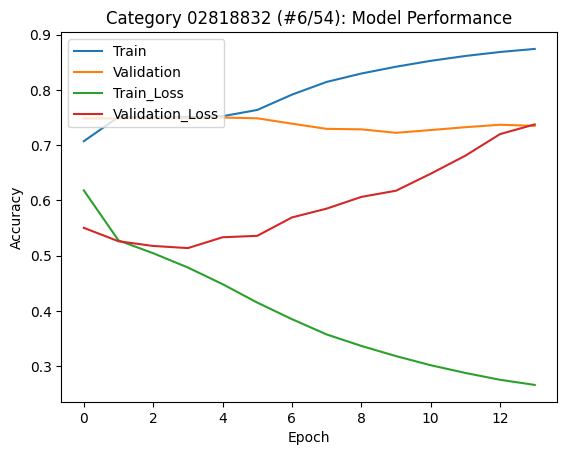

Starting training model for category #7/10: 02828884
x_train shape: (14504, 128, 128, 1)
x_test shape: (3626, 128, 128, 1)
y_train shape: (14504, 32, 32, 32, 1)
y_test shape: (3626, 32, 32, 32, 1)
Epoch 1/100
363/363 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.8031
Epoch 1: val_accuracy improved from -inf to 0.81405, saving model to models/128x32\02828884.keras
363/363 [==============================] - 68s 186ms/step - loss: 0.4174 - accuracy: 0.8031 - val_loss: 0.3591 - val_accuracy: 0.8141
Epoch 2/100
363/363 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.8341
Epoch 2: val_accuracy improved from 0.81405 to 0.84453, saving model to models/128x32\02828884.keras
363/363 [==============================] - 62s 172ms/step - loss: 0.3433 - accuracy: 0.8341 - val_loss: 0.3302 - val_accuracy: 0.8445
Epoch 3/100
363/363 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.8556
Epoch 3: val_accuracy improved from 0.84453 t

INFO:tensorflow:Assets written to: ram://29420365-fe82-48f2-af97-6570f795c6f9/assets


INFO:tensorflow:Assets written to: ram://29420365-fe82-48f2-af97-6570f795c6f9/assets


Evaluating best model on category 02828884, input: 128, output: 32.
114/114 [==============================] - 57s 502ms/step - loss: 0.3916 - accuracy: 0.8579
Test Loss: 0.39157602190971375, Test Accuracy: 0.8578968644142151


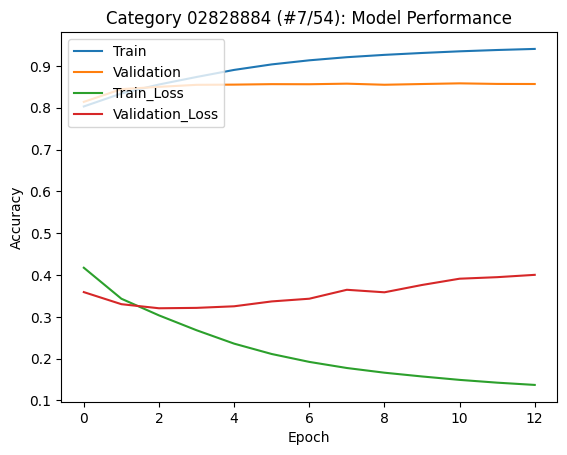

Starting training model for category #8/10: 02843684
x_train shape: (584, 128, 128, 1)
x_test shape: (146, 128, 128, 1)
y_train shape: (584, 32, 32, 32, 1)
y_test shape: (146, 32, 32, 32, 1)
Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.6010 - accuracy: 0.7235
Epoch 1: val_accuracy improved from -inf to 0.76261, saving model to models/128x32\02843684.keras
15/15 [==============================] - 26s 2s/step - loss: 0.6010 - accuracy: 0.7235 - val_loss: 0.5364 - val_accuracy: 0.7626
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.5000 - accuracy: 0.7679
Epoch 2: val_accuracy improved from 0.76261 to 0.76280, saving model to models/128x32\02843684.keras
15/15 [==============================] - 22s 2s/step - loss: 0.5000 - accuracy: 0.7679 - val_loss: 0.4878 - val_accuracy: 0.7628
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.4623 - accuracy: 0.7679
Epoch 3: val_accuracy improved from 0.76280 to 0.76281, saving mode

INFO:tensorflow:Assets written to: ram://e0f5331f-e3c4-4048-9294-7f59e2039202/assets


INFO:tensorflow:Assets written to: ram://e0f5331f-e3c4-4048-9294-7f59e2039202/assets


Evaluating best model on category 02843684, input: 128, output: 32.
5/5 [==============================] - 2s 424ms/step - loss: 0.6643 - accuracy: 0.7928
Test Loss: 0.6643093824386597, Test Accuracy: 0.7928054928779602


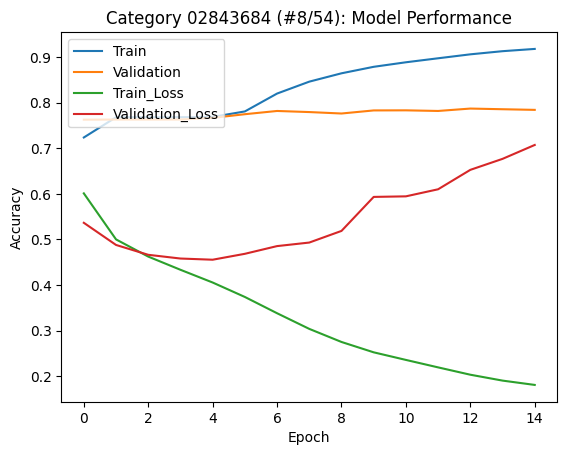

Starting training model for category #9/10: 02871439
x_train shape: (3616, 128, 128, 1)
x_test shape: (904, 128, 128, 1)
y_train shape: (3616, 32, 32, 32, 1)
y_test shape: (904, 32, 32, 32, 1)
Epoch 1/100
91/91 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.6061
Epoch 1: val_accuracy improved from -inf to 0.63788, saving model to models/128x32\02871439.keras
91/91 [==============================] - 32s 348ms/step - loss: 0.6950 - accuracy: 0.6061 - val_loss: 0.6643 - val_accuracy: 0.6379
Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 0.6471 - accuracy: 0.6482
Epoch 2: val_accuracy improved from 0.63788 to 0.65116, saving model to models/128x32\02871439.keras
91/91 [==============================] - 31s 337ms/step - loss: 0.6471 - accuracy: 0.6482 - val_loss: 0.6384 - val_accuracy: 0.6512
Epoch 3/100
91/91 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.6688
Epoch 3: val_accuracy improved from 0.65116 to 0.67573, sav

INFO:tensorflow:Assets written to: ram://768d74bd-1271-457d-abea-fa1ec34d2825/assets


INFO:tensorflow:Assets written to: ram://768d74bd-1271-457d-abea-fa1ec34d2825/assets


Evaluating best model on category 02871439, input: 128, output: 32.
29/29 [==============================] - 14s 470ms/step - loss: 0.6743 - accuracy: 0.6867
Test Loss: 0.6743332147598267, Test Accuracy: 0.686691164970398


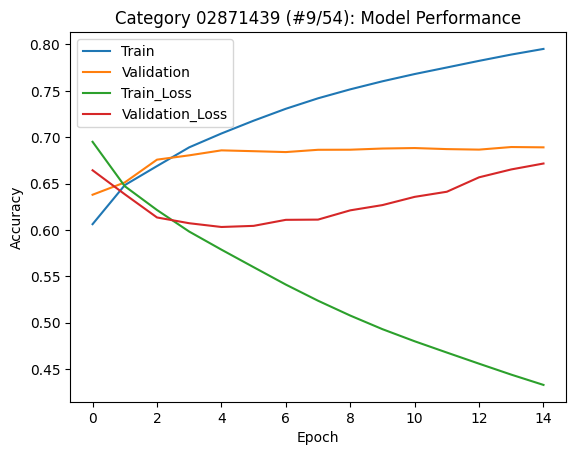

Starting training model for category #10/10: 02876657
x_train shape: (3984, 128, 128, 1)
x_test shape: (996, 128, 128, 1)
y_train shape: (3984, 32, 32, 32, 1)
y_test shape: (996, 32, 32, 32, 1)
Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.4991 - accuracy: 0.7273
Epoch 1: val_accuracy improved from -inf to 0.74095, saving model to models/128x32\02876657.keras
100/100 [==============================] - 33s 326ms/step - loss: 0.4991 - accuracy: 0.7273 - val_loss: 0.4319 - val_accuracy: 0.7409
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.7718
Epoch 2: val_accuracy improved from 0.74095 to 0.80787, saving model to models/128x32\02876657.keras
100/100 [==============================] - 36s 363ms/step - loss: 0.4042 - accuracy: 0.7718 - val_loss: 0.3883 - val_accuracy: 0.8079
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8320
Epoch 3: val_accuracy improved from 0.80787 to 0

INFO:tensorflow:Assets written to: ram://d922579a-bab0-405e-a3c6-2381b1bd90c1/assets


INFO:tensorflow:Assets written to: ram://d922579a-bab0-405e-a3c6-2381b1bd90c1/assets


Evaluating best model on category 02876657, input: 128, output: 32.
32/32 [==============================] - 15s 463ms/step - loss: 0.2244 - accuracy: 0.9343
Test Loss: 0.22443266212940216, Test Accuracy: 0.9343471527099609


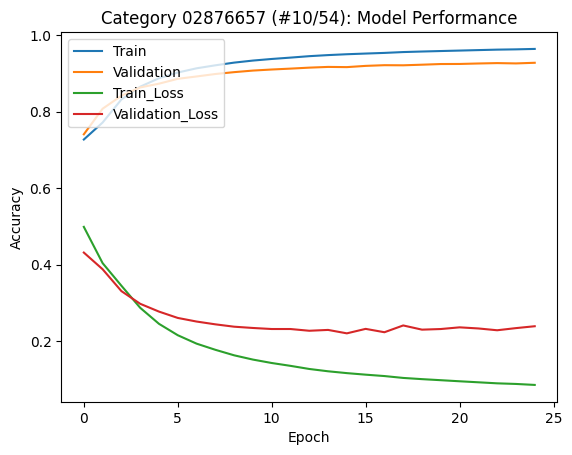

In [12]:
from keras.backend import clear_session
import gc

def train_models_all_categories(categories, input_shape, output_shape, images_per_voxel, test_size, validation_split, initial_cat_index=0):
    
    # Set strings with the input and output reso and title
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])

    # Empty dictionary that will contain all metrics
    metric_values = {}
    
    for i, category in enumerate(categories):
        print(f'Starting training model for category #{str(i+initial_cat_index+1)}/{len(categories)+initial_cat_index}: {category}')

        # Load and Split the data
        x_train, x_test, y_train, y_test = split_data(category, input_shape, output_shape, images_per_voxel, test_size)

        # Print subsets shape
        print(f'x_train shape: {x_train.shape}\nx_test shape: {x_test.shape}\ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')
        
        # Train model
        model_history = train_model_one_category(category, x_train, x_test, y_train, y_test, input_shape, output_shape, validation_split)

        # Save model history dictionary as pickle file
        save_dictionary_as_pickle(f'history/{input_reso}x{output_reso}/', f'{category}.pkl', model_history)
        
        # Evaluate model and save values
        loss, accuracy = evaluate_best_model(category, x_test, y_test, input_shape, output_shape, run_on_gpu=False)
        metric_values[category] = (loss, accuracy)
        
        # Save all metrics values on every iteration to avoid losing values
        save_dictionary_as_pickle(f'history/{input_reso}x{output_reso}/', f'metrics-{initial_cat_index+1}-{initial_cat_index+len(categories)}.pkl', metric_values)

        # Plot model performance
        plot_model_performance(category, initial_cat_index + i, input_shape, output_shape, model_history)

        # Free RAM resources
        clear_session()
        del x_train, x_test, y_train, y_test, model_history
        gc.collect()


train_models_all_categories(categories[5:10],
                            input_shape=(128, 128, 1),
                            output_shape=(32, 32, 32, 1),
                            images_per_voxel=10,
                            test_size=0.2,
                            validation_split=0.2,
                            initial_cat_index=5)

Starting training model for category #11/20: 02880940
x_train shape: (1488, 128, 128, 1)
x_test shape: (372, 128, 128, 1)
y_train shape: (1488, 32, 32, 32, 1)
y_test shape: (372, 32, 32, 32, 1)
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 0.4847 - accuracy: 0.7772
Epoch 1: val_accuracy improved from -inf to 0.80165, saving model to models/128x32\02880940.keras
38/38 [==============================] - 26s 672ms/step - loss: 0.4847 - accuracy: 0.7772 - val_loss: 0.3703 - val_accuracy: 0.8016
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 0.3587 - accuracy: 0.8021
Epoch 2: val_accuracy improved from 0.80165 to 0.80692, saving model to models/128x32\02880940.keras
38/38 [==============================] - 27s 719ms/step - loss: 0.3587 - accuracy: 0.8021 - val_loss: 0.3380 - val_accuracy: 0.8069
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 0.3258 - accuracy: 0.8152
Epoch 3: val_accuracy improved from 0.80692 to 0.83468, sa

INFO:tensorflow:Assets written to: ram://a10ec76b-47b1-404b-b61d-a89129bf117f/assets


INFO:tensorflow:Assets written to: ram://a10ec76b-47b1-404b-b61d-a89129bf117f/assets


Evaluating best model on category 02880940, input: 128, output: 32.
12/12 [==============================] - 6s 484ms/step - loss: 0.1723 - accuracy: 0.9508
Test Loss: 0.17229370772838593, Test Accuracy: 0.9507592916488647


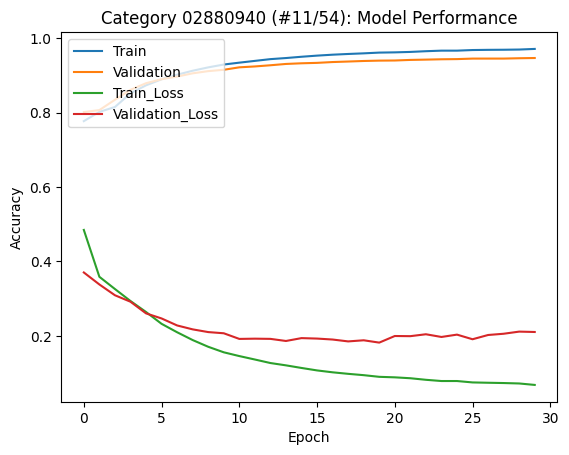

Starting training model for category #12/20: 02924116
x_train shape: (7512, 128, 128, 1)
x_test shape: (1878, 128, 128, 1)
y_train shape: (7512, 32, 32, 32, 1)
y_test shape: (1878, 32, 32, 32, 1)
Epoch 1/100
188/188 [==============================] - ETA: 0s - loss: 0.5922 - accuracy: 0.6760
Epoch 1: val_accuracy improved from -inf to 0.70194, saving model to models/128x32\02924116.keras
188/188 [==============================] - 46s 243ms/step - loss: 0.5922 - accuracy: 0.6760 - val_loss: 0.5671 - val_accuracy: 0.7019
Epoch 2/100
188/188 [==============================] - ETA: 0s - loss: 0.5604 - accuracy: 0.7063
Epoch 2: val_accuracy improved from 0.70194 to 0.71366, saving model to models/128x32\02924116.keras
188/188 [==============================] - 47s 248ms/step - loss: 0.5604 - accuracy: 0.7063 - val_loss: 0.5518 - val_accuracy: 0.7137
Epoch 3/100
188/188 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.7260
Epoch 3: val_accuracy improved from 0.71366 to

INFO:tensorflow:Assets written to: ram://ae411ac0-4d6a-4e76-9e6f-d4bc37584780/assets


INFO:tensorflow:Assets written to: ram://ae411ac0-4d6a-4e76-9e6f-d4bc37584780/assets


Evaluating best model on category 02924116, input: 128, output: 32.
59/59 [==============================] - 36s 599ms/step - loss: 0.5481 - accuracy: 0.7216
Test Loss: 0.5481075048446655, Test Accuracy: 0.7216292023658752


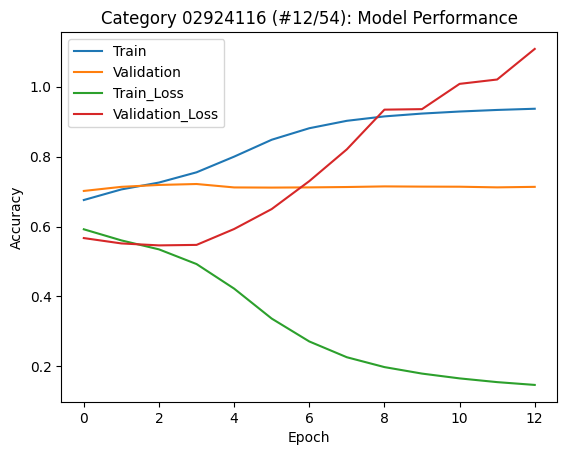

Starting training model for category #13/20: 02933112
x_train shape: (12568, 128, 128, 1)
x_test shape: (3142, 128, 128, 1)
y_train shape: (12568, 32, 32, 32, 1)
y_test shape: (3142, 32, 32, 32, 1)
Epoch 1/100
315/315 [==============================] - ETA: 0s - loss: 0.6107 - accuracy: 0.6699
Epoch 1: val_accuracy improved from -inf to 0.70010, saving model to models/128x32\02933112.keras
315/315 [==============================] - 61s 190ms/step - loss: 0.6107 - accuracy: 0.6699 - val_loss: 0.5769 - val_accuracy: 0.7001
Epoch 2/100
315/315 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.7070
Epoch 2: val_accuracy improved from 0.70010 to 0.71071, saving model to models/128x32\02933112.keras
315/315 [==============================] - 59s 186ms/step - loss: 0.5662 - accuracy: 0.7070 - val_loss: 0.5594 - val_accuracy: 0.7107
Epoch 3/100
315/315 [==============================] - ETA: 0s - loss: 0.5423 - accuracy: 0.7199
Epoch 3: val_accuracy improved from 0.71071 

INFO:tensorflow:Assets written to: ram://66110bf9-b9a9-4c31-821a-fb46ffbcbf87/assets


INFO:tensorflow:Assets written to: ram://66110bf9-b9a9-4c31-821a-fb46ffbcbf87/assets


Evaluating best model on category 02933112, input: 128, output: 32.
99/99 [==============================] - 50s 507ms/step - loss: 0.5444 - accuracy: 0.7206
Test Loss: 0.5444342494010925, Test Accuracy: 0.7206225395202637


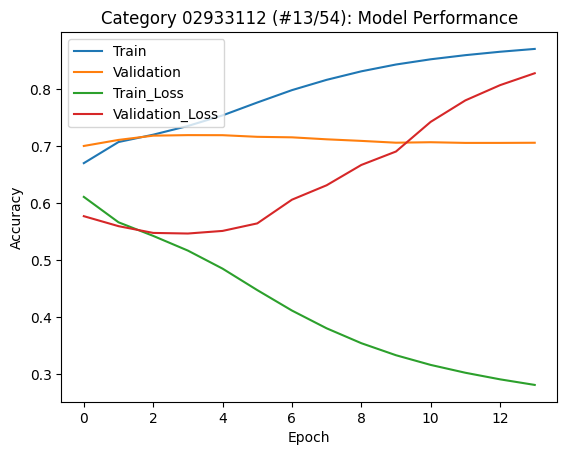

Starting training model for category #14/20: 02942699
x_train shape: (904, 128, 128, 1)
x_test shape: (226, 128, 128, 1)
y_train shape: (904, 32, 32, 32, 1)
y_test shape: (226, 32, 32, 32, 1)
Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 0.5645 - accuracy: 0.7597
Epoch 1: val_accuracy improved from -inf to 0.77748, saving model to models/128x32\02942699.keras
23/23 [==============================] - 23s 1s/step - loss: 0.5645 - accuracy: 0.7597 - val_loss: 0.5114 - val_accuracy: 0.7775
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.7807
Epoch 2: val_accuracy did not improve from 0.77748
23/23 [==============================] - 3s 121ms/step - loss: 0.4956 - accuracy: 0.7807 - val_loss: 0.4960 - val_accuracy: 0.7775
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 0.4733 - accuracy: 0.7807
Epoch 3: val_accuracy did not improve from 0.77748
23/23 [==============================] - 3s 122ms/step - loss: 

INFO:tensorflow:Assets written to: ram://5abebae5-41f9-4778-a157-e2ecc62c76a0/assets


INFO:tensorflow:Assets written to: ram://5abebae5-41f9-4778-a157-e2ecc62c76a0/assets


Evaluating best model on category 02942699, input: 128, output: 32.
8/8 [==============================] - 4s 477ms/step - loss: 0.5071 - accuracy: 0.7883
Test Loss: 0.5070977210998535, Test Accuracy: 0.788343608379364


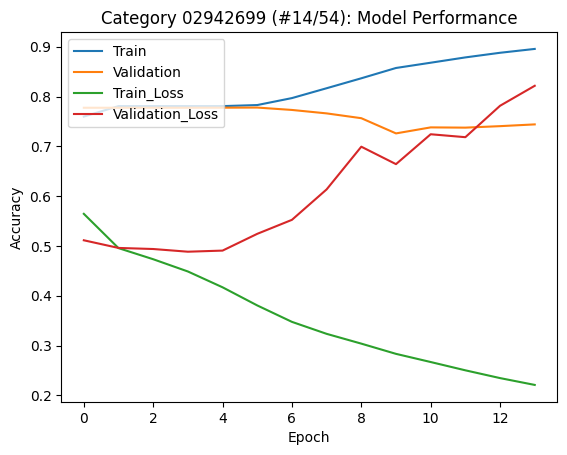

Starting training model for category #15/20: 02946921
x_train shape: (864, 128, 128, 1)
x_test shape: (216, 128, 128, 1)
y_train shape: (864, 32, 32, 32, 1)
y_test shape: (216, 32, 32, 32, 1)
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.5335 - accuracy: 0.7192
Epoch 1: val_accuracy improved from -inf to 0.75652, saving model to models/128x32\02946921.keras
22/22 [==============================] - 38s 2s/step - loss: 0.5335 - accuracy: 0.7192 - val_loss: 0.4342 - val_accuracy: 0.7565
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.3846 - accuracy: 0.7752
Epoch 2: val_accuracy improved from 0.75652 to 0.79837, saving model to models/128x32\02946921.keras
22/22 [==============================] - 29s 1s/step - loss: 0.3846 - accuracy: 0.7752 - val_loss: 0.3713 - val_accuracy: 0.7984
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.8236
Epoch 3: val_accuracy improved from 0.79837 to 0.83434, saving mod

MemoryError: Unable to allocate 1.00 GiB for an array with shape (65536, 4096) and data type float32

In [13]:
from keras.backend import clear_session
import gc

def train_models_all_categories(categories, input_shape, output_shape, images_per_voxel, test_size, validation_split, initial_cat_index=0):
    
    # Set strings with the input and output reso and title
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])

    # Empty dictionary that will contain all metrics
    metric_values = {}
    
    for i, category in enumerate(categories):
        print(f'Starting training model for category #{str(i+initial_cat_index+1)}/{len(categories)+initial_cat_index}: {category}')

        # Load and Split the data
        x_train, x_test, y_train, y_test = split_data(category, input_shape, output_shape, images_per_voxel, test_size)

        # Print subsets shape
        print(f'x_train shape: {x_train.shape}\nx_test shape: {x_test.shape}\ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')
        
        # Train model
        model_history = train_model_one_category(category, x_train, x_test, y_train, y_test, input_shape, output_shape, validation_split)

        # Save model history dictionary as pickle file
        save_dictionary_as_pickle(f'history/{input_reso}x{output_reso}/', f'{category}.pkl', model_history)
        
        # Evaluate model and save values
        loss, accuracy = evaluate_best_model(category, x_test, y_test, input_shape, output_shape, run_on_gpu=False)
        metric_values[category] = (loss, accuracy)
        
        # Save all metrics values on every iteration to avoid losing values
        save_dictionary_as_pickle(f'history/{input_reso}x{output_reso}/', f'metrics-{initial_cat_index+1}-{initial_cat_index+len(categories)}.pkl', metric_values)

        # Plot model performance
        plot_model_performance(category, initial_cat_index + i, input_shape, output_shape, model_history)

        # Free RAM resources
        clear_session()
        del x_train, x_test, y_train, y_test, model_history
        gc.collect()


train_models_all_categories(categories[10:20],
                            input_shape=(128, 128, 1),
                            output_shape=(32, 32, 32, 1),
                            images_per_voxel=10,
                            test_size=0.2,
                            validation_split=0.2,
                            initial_cat_index=10)

Starting training model for category #1/1: 02691156
x_train shape: (2831, 128, 128, 1)
x_test shape: (1214, 128, 128, 1)
y_train shape: (2831, 32, 32, 32, 1)
y_test shape: (1214, 32, 32, 32, 1)
Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.2949 - accuracy: 0.8991
Epoch 1: val_accuracy improved from -inf to 0.91297, saving model to models/1x128x32\02691156.keras
62/62 [==============================] - 6s 75ms/step - loss: 0.2949 - accuracy: 0.8991 - val_loss: 0.2788 - val_accuracy: 0.9130
Epoch 2/100
61/62 [============================>.] - ETA: 0s - loss: 0.1975 - accuracy: 0.9139
Epoch 2: val_accuracy improved from 0.91297 to 0.92007, saving model to models/1x128x32\02691156.keras
62/62 [==============================] - 4s 68ms/step - loss: 0.1973 - accuracy: 0.9140 - val_loss: 0.2386 - val_accuracy: 0.9201
Epoch 3/100
61/62 [============================>.] - ETA: 0s - loss: 0.1843 - accuracy: 0.9225
Epoch 3: val_accuracy improved from 0.92007 to 0.92955, sa

INFO:tensorflow:Assets written to: ram://ae7cbc49-0661-49d8-acf4-e75b29013a65/assets


INFO:tensorflow:Assets written to: ram://ae7cbc49-0661-49d8-acf4-e75b29013a65/assets


Evaluating best model on category 02691156, input: 128, output: 32.
38/38 [==============================] - 12s 299ms/step - loss: 0.1531 - accuracy: 0.9367
Test Loss: 0.15314331650733948, Test Accuracy: 0.9367251396179199


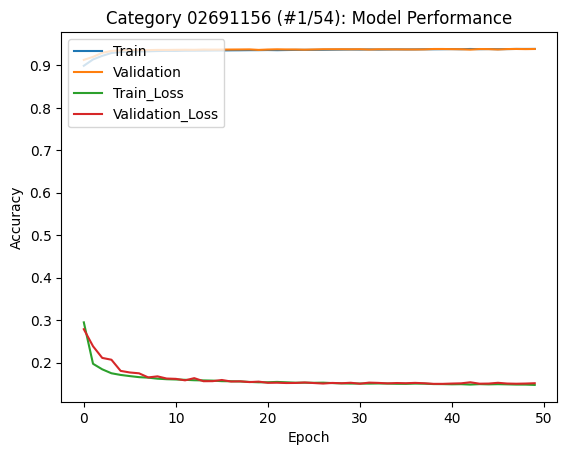

In [122]:
from keras.backend import clear_session
import gc

def train_models_all_categories(categories, input_shape, output_shape, images_per_voxel, test_size, validation_split, initial_cat_index=0):
    
    # Set strings with the input and output reso and title
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])

    # Empty dictionary that will contain all metrics
    metric_values = {}
    
    for i, category in enumerate(categories):
        print(f'Starting training model for category #{str(i+initial_cat_index+1)}/{len(categories)+initial_cat_index}: {category}')

        # Load and Split the data
        x_train, x_test, y_train, y_test = split_data(category, input_shape, output_shape, images_per_voxel, test_size)

        # Print subsets shape
        print(f'x_train shape: {x_train.shape}\nx_test shape: {x_test.shape}\ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')
        
        # Train model
        model, model_history = train_model_one_category(category, x_train, x_test, y_train, y_test, input_shape, output_shape, images_per_voxel, validation_split)

        # Save model history dictionary as pickle file
        save_dictionary_as_pickle(f'history/{images_per_voxel}x{input_reso}x{output_reso}/', f'{category}.pkl', model_history)
        
        # Evaluate model and save values
        loss, accuracy = evaluate_best_model(category, x_test, y_test, input_shape, output_shape, images_per_voxel, run_on_gpu=False)
        metric_values[category] = (loss, accuracy)
        
        # Save all metrics values on every iteration to avoid losing values
        save_dictionary_as_pickle(f'history/{images_per_voxel}x{input_reso}x{output_reso}/', f'metrics-{initial_cat_index+1}-{initial_cat_index+len(categories)}.pkl', metric_values)

        # Plot model performance
        plot_model_performance(category, initial_cat_index + i, input_shape, output_shape, images_per_voxel, model_history)

        # Free RAM resources
        clear_session()
        del x_train, x_test, y_train, y_test, model_history
        gc.collect()

    return model


test_model = train_models_all_categories(categories[:1],
                            input_shape=(128, 128, 1),
                            output_shape=(32, 32, 32, 1),
                            images_per_voxel=1,
                            test_size=0.3,
                            validation_split=0.3,
                            initial_cat_index=0)

In [127]:
from tensorflow.keras import layers, models, regularizers

def build_cnn_model(input_shape, output_shape):
    model = models.Sequential()

    # Encoder (2D Convolutions for 2D image input)
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.3))  # Regularization to reduce overfitting

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.4))

    # Latent Space
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))  # Reduced latent space
    model.add(layers.Dropout(0.5)) # original 0.4
    model.add(layers.Dense(4 * 4 * 4 * 16, activation='relu'))  # Smaller output for decoder
    model.add(layers.Reshape((4, 4, 4, 16)))

    # Decoder (3D Convolutions for voxel grid output)
    model.add(layers.Conv3DTranspose(64, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Conv3DTranspose(32, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Conv3DTranspose(16, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same'))  # Sigmoid for binary output


    return model

test_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 64, 64, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 32, 32, 32)       

In [111]:
from tensorflow.keras import layers, models, regularizers

def build_cnn_model(input_shape, output_shape):
    model = models.Sequential()

    # Encoder (2D Convolutions for 2D image input)
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.3))  # Dropout to reduce overfitting

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.4))

    # Latent Space
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.Dropout(0.5))  # Strong dropout for the dense layer
    model.add(layers.Dense(4 * 4 * 4 * 64, activation='relu'))
    model.add(layers.Reshape((4, 4, 4, 64)))

    # Decoder (3D Convolutions for voxel grid output)
    model.add(layers.Conv3DTranspose(64, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Conv3DTranspose(32, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Conv3DTranspose(16, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same'))  # Sigmoid for binary output

    return model

test_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 64)       

In [106]:
from tensorflow.keras import layers, models, regularizers

def build_cnn_model(input_shape, output_shape):
    model = models.Sequential()

    # Encoder (2D Convolutions)
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.3))  # Add Dropout after pooling
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Dropout(0.4))
    
    # Latent Space
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.Dropout(0.5))  # Increase Dropout for dense layer
    model.add(layers.Dense(4 * 4 * 4 * 32, activation='relu'))
    model.add(layers.Reshape((4, 4, 4, 32)))
    
    # Decoder (3D Convolutions)
    model.add(layers.Conv3DTranspose(32, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv3DTranspose(16, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv3DTranspose(8, (3, 3, 3), strides=(2, 2, 2), padding='same', activation='relu'))
    model.add(layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same'))
    
    return model

test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       2

Starting training model for category #13/54: 02933112
x_train shape: (1256, 128, 128, 1)
x_test shape: (315, 128, 128, 1)
y_train shape: (1256, 32, 32, 32, 1)
y_test shape: (315, 32, 32, 32, 1)
Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 0.6629 - accuracy: 0.6037
Epoch 1: val_accuracy improved from -inf to 0.61646, saving model to models/1x128x32\02933112.keras
32/32 [==============================] - 25s 766ms/step - loss: 0.6629 - accuracy: 0.6037 - val_loss: 0.6324 - val_accuracy: 0.6165
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 0.6248 - accuracy: 0.6262
Epoch 2: val_accuracy improved from 0.61646 to 0.62517, saving model to models/1x128x32\02933112.keras
32/32 [==============================] - 23s 728ms/step - loss: 0.6248 - accuracy: 0.6262 - val_loss: 0.6145 - val_accuracy: 0.6252
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 0.6011 - accuracy: 0.6589
Epoch 3: val_accuracy improved from 0.62517 to 0.69166

INFO:tensorflow:Assets written to: ram://bc5ee843-0e29-4ddc-b495-a97a04371189/assets


INFO:tensorflow:Assets written to: ram://bc5ee843-0e29-4ddc-b495-a97a04371189/assets


Evaluating best model on category 02933112, input: 128, output: 32.
10/10 [==============================] - 5s 461ms/step - loss: 0.5899 - accuracy: 0.7098
Test Loss: 0.5899264812469482, Test Accuracy: 0.7098482847213745


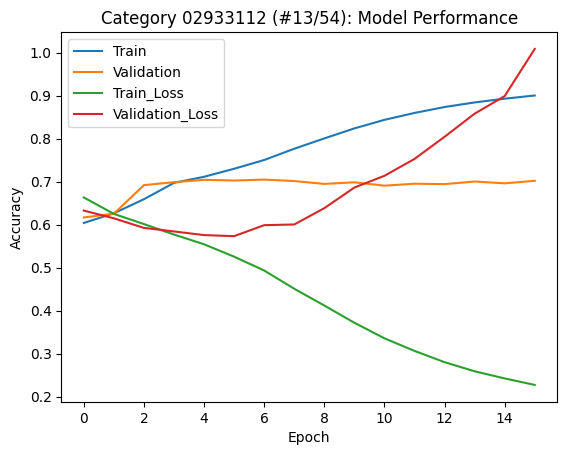

Starting training model for category #14/54: 02942699
x_train shape: (90, 128, 128, 1)
x_test shape: (23, 128, 128, 1)
y_train shape: (90, 32, 32, 32, 1)
y_test shape: (23, 32, 32, 32, 1)
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.5206 - accuracy: 0.7165
Epoch 1: val_accuracy improved from -inf to 0.69743, saving model to models/1x128x32\02942699.keras
3/3 [==============================] - 21s 10s/step - loss: 1.5206 - accuracy: 0.7165 - val_loss: 0.6424 - val_accuracy: 0.6974
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.6566
Epoch 2: val_accuracy did not improve from 0.69743
3/3 [==============================] - 1s 119ms/step - loss: 0.6555 - accuracy: 0.6566 - val_loss: 0.6763 - val_accuracy: 0.6221
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.6781 - accuracy: 0.6041
Epoch 3: val_accuracy did not improve from 0.69743
3/3 [==============================] - 0s 114ms/step - loss: 0.6781 - accu

INFO:tensorflow:Assets written to: ram://67a4aa34-e13e-430f-bc9f-e7eac934e21d/assets


INFO:tensorflow:Assets written to: ram://67a4aa34-e13e-430f-bc9f-e7eac934e21d/assets


Evaluating best model on category 02942699, input: 128, output: 32.
1/1 [==============================] - 1s 561ms/step - loss: 0.5081 - accuracy: 0.7718
Test Loss: 0.5080798864364624, Test Accuracy: 0.7717524170875549


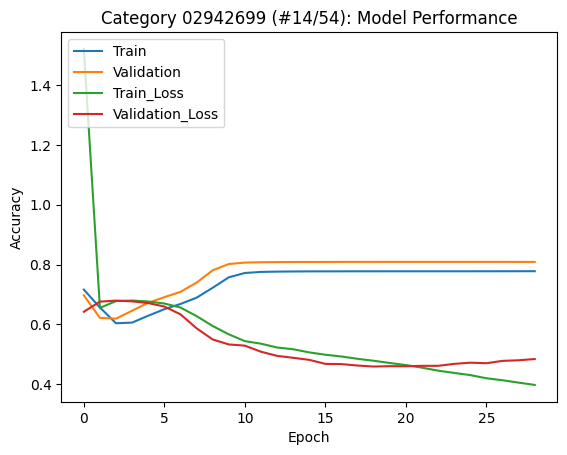

Starting training model for category #15/54: 02946921
x_train shape: (86, 128, 128, 1)
x_test shape: (22, 128, 128, 1)
y_train shape: (86, 32, 32, 32, 1)
y_test shape: (22, 32, 32, 32, 1)
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.6837 - accuracy: 0.5387
Epoch 1: val_accuracy improved from -inf to 0.76202, saving model to models/1x128x32\02946921.keras
3/3 [==============================] - 25s 12s/step - loss: 0.6837 - accuracy: 0.5387 - val_loss: 0.5178 - val_accuracy: 0.7620
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.5251 - accuracy: 0.7582
Epoch 2: val_accuracy improved from 0.76202 to 0.76712, saving model to models/1x128x32\02946921.keras
3/3 [==============================] - 20s 10s/step - loss: 0.5251 - accuracy: 0.7582 - val_loss: 0.4820 - val_accuracy: 0.7671
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.7615
Epoch 3: val_accuracy improved from 0.76712 to 0.76752, saving model to mo

INFO:tensorflow:Assets written to: ram://e58597a8-3b79-4e42-ae90-05c124483880/assets


INFO:tensorflow:Assets written to: ram://e58597a8-3b79-4e42-ae90-05c124483880/assets


Evaluating best model on category 02946921, input: 128, output: 32.
1/1 [==============================] - 1s 572ms/step - loss: 0.3358 - accuracy: 0.8429
Test Loss: 0.3357965350151062, Test Accuracy: 0.8428594470024109


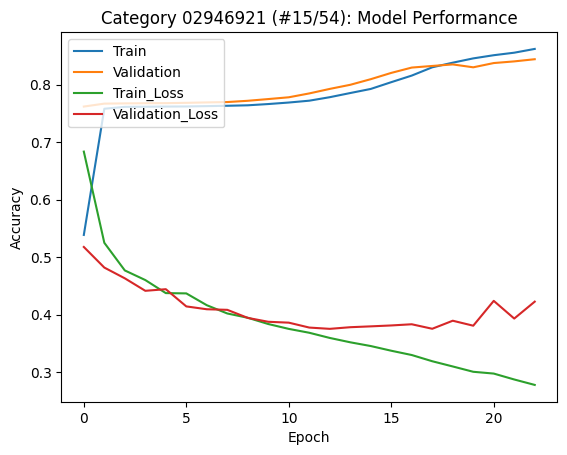

Starting training model for category #16/54: 02954340
x_train shape: (44, 128, 128, 1)
x_test shape: (12, 128, 128, 1)
y_train shape: (44, 32, 32, 32, 1)
y_test shape: (12, 32, 32, 32, 1)
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.5751
Epoch 1: val_accuracy improved from -inf to 0.80977, saving model to models/1x128x32\02954340.keras
2/2 [==============================] - 25s 25s/step - loss: 0.6760 - accuracy: 0.5751 - val_loss: 0.5168 - val_accuracy: 0.8098
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.8295
Epoch 2: val_accuracy improved from 0.80977 to 0.82968, saving model to models/1x128x32\02954340.keras
2/2 [==============================] - 22s 21s/step - loss: 0.4719 - accuracy: 0.8295 - val_loss: 0.4662 - val_accuracy: 0.8297
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.4160 - accuracy: 0.8489
Epoch 3: val_accuracy improved from 0.82968 to 0.83199, saving model to mo

INFO:tensorflow:Assets written to: ram://fc255c30-50c3-4bfd-a3a6-c5628673c5ad/assets


INFO:tensorflow:Assets written to: ram://fc255c30-50c3-4bfd-a3a6-c5628673c5ad/assets


Evaluating best model on category 02954340, input: 128, output: 32.
1/1 [==============================] - 1s 630ms/step - loss: 0.4506 - accuracy: 0.8416
Test Loss: 0.4506395161151886, Test Accuracy: 0.8416213989257812


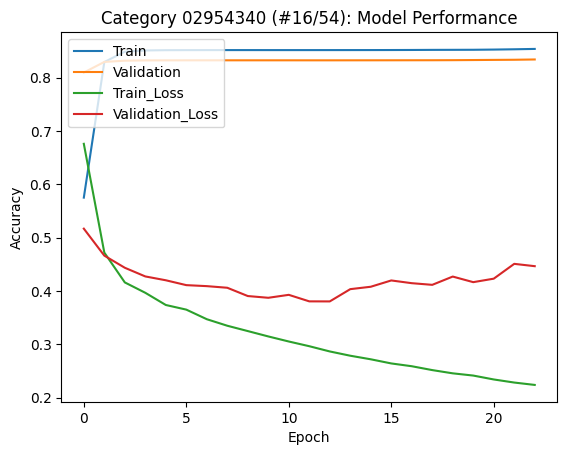

Starting training model for category #17/54: 02992529
x_train shape: (664, 128, 128, 1)
x_test shape: (167, 128, 128, 1)
y_train shape: (664, 32, 32, 32, 1)
y_test shape: (167, 32, 32, 32, 1)
Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 0.6739 - accuracy: 0.5589
Epoch 1: val_accuracy improved from -inf to 0.56954, saving model to models/1x128x32\02992529.keras
17/17 [==============================] - 27s 2s/step - loss: 0.6739 - accuracy: 0.5589 - val_loss: 0.6617 - val_accuracy: 0.5695
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 0.6398 - accuracy: 0.6236
Epoch 2: val_accuracy improved from 0.56954 to 0.64094, saving model to models/1x128x32\02992529.keras
17/17 [==============================] - 21s 1s/step - loss: 0.6398 - accuracy: 0.6236 - val_loss: 0.6360 - val_accuracy: 0.6409
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 0.6172 - accuracy: 0.6683
Epoch 3: val_accuracy improved from 0.64094 to 0.65349, saving

INFO:tensorflow:Assets written to: ram://723287d1-076b-4c21-97f9-6ca4ce57ce7b/assets


INFO:tensorflow:Assets written to: ram://723287d1-076b-4c21-97f9-6ca4ce57ce7b/assets


Evaluating best model on category 02992529, input: 128, output: 32.
6/6 [==============================] - 3s 408ms/step - loss: 0.5887 - accuracy: 0.6965
Test Loss: 0.5887393951416016, Test Accuracy: 0.696463942527771


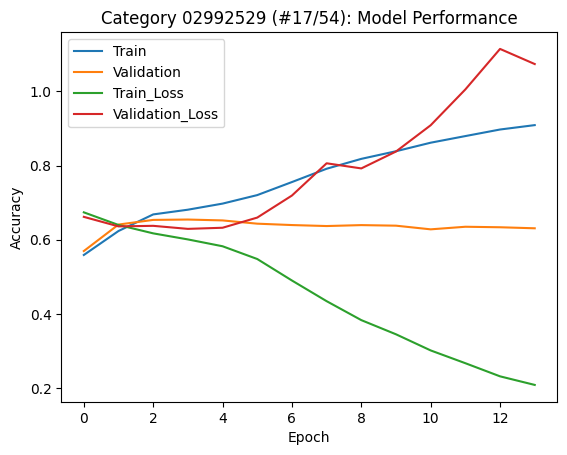

Starting training model for category #18/54: 03001627
x_train shape: (5422, 128, 128, 1)
x_test shape: (1356, 128, 128, 1)
y_train shape: (5422, 32, 32, 32, 1)
y_test shape: (1356, 32, 32, 32, 1)
Epoch 1/100
136/136 [==============================] - ETA: 0s - loss: 0.3692 - accuracy: 0.8364
Epoch 1: val_accuracy improved from -inf to 0.84525, saving model to models/1x128x32\03001627.keras
136/136 [==============================] - 41s 300ms/step - loss: 0.3692 - accuracy: 0.8364 - val_loss: 0.3347 - val_accuracy: 0.8452
Epoch 2/100
136/136 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8448
Epoch 2: val_accuracy improved from 0.84525 to 0.84623, saving model to models/1x128x32\03001627.keras
136/136 [==============================] - 36s 261ms/step - loss: 0.3241 - accuracy: 0.8448 - val_loss: 0.3250 - val_accuracy: 0.8462
Epoch 3/100
136/136 [==============================] - ETA: 0s - loss: 0.3045 - accuracy: 0.8476
Epoch 3: val_accuracy improved from 0.8462

INFO:tensorflow:Assets written to: ram://c56197fb-83cb-45f8-8d7a-36319e1ea787/assets


INFO:tensorflow:Assets written to: ram://c56197fb-83cb-45f8-8d7a-36319e1ea787/assets


Evaluating best model on category 03001627, input: 128, output: 32.
43/43 [==============================] - 21s 479ms/step - loss: 0.3179 - accuracy: 0.8484
Test Loss: 0.31793299317359924, Test Accuracy: 0.8483941555023193


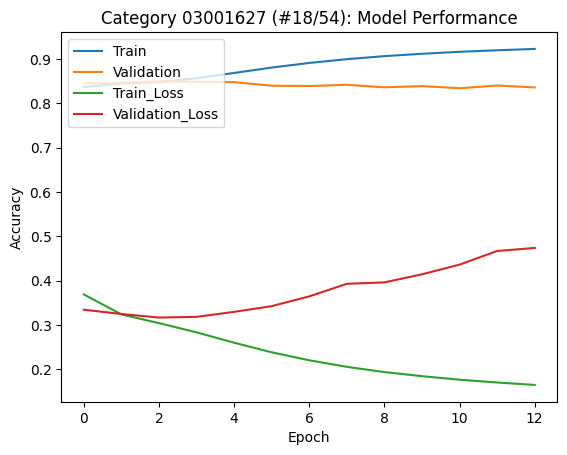

Starting training model for category #19/54: 03046257
x_train shape: (520, 128, 128, 1)
x_test shape: (131, 128, 128, 1)
y_train shape: (520, 32, 32, 32, 1)
y_test shape: (131, 32, 32, 32, 1)
Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.5882
Epoch 1: val_accuracy improved from -inf to 0.63707, saving model to models/1x128x32\03046257.keras
13/13 [==============================] - 22s 2s/step - loss: 0.6686 - accuracy: 0.5882 - val_loss: 0.6258 - val_accuracy: 0.6371
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.6141 - accuracy: 0.6173
Epoch 2: val_accuracy improved from 0.63707 to 0.63870, saving model to models/1x128x32\03046257.keras
13/13 [==============================] - 20s 2s/step - loss: 0.6141 - accuracy: 0.6173 - val_loss: 0.6045 - val_accuracy: 0.6387
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.5817 - accuracy: 0.6223
Epoch 3: val_accuracy improved from 0.63870 to 0.64628, saving

INFO:tensorflow:Assets written to: ram://8d7b21c1-e28d-4062-aa2c-dd11f3622d91/assets


INFO:tensorflow:Assets written to: ram://8d7b21c1-e28d-4062-aa2c-dd11f3622d91/assets


Evaluating best model on category 03046257, input: 128, output: 32.
5/5 [==============================] - 2s 376ms/step - loss: 0.6013 - accuracy: 0.6535
Test Loss: 0.6013256311416626, Test Accuracy: 0.6534665822982788


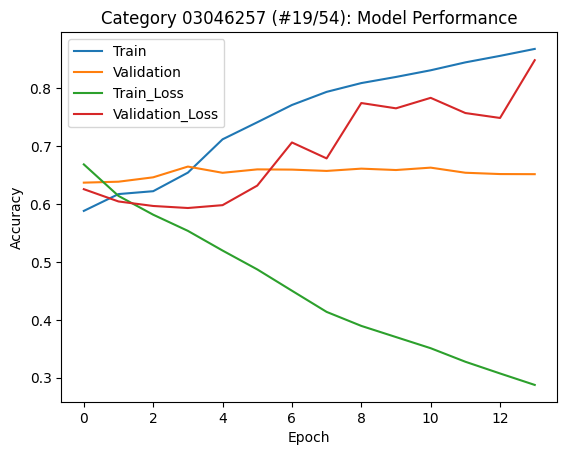

Starting training model for category #20/54: 03085013
x_train shape: (52, 128, 128, 1)
x_test shape: (13, 128, 128, 1)
y_train shape: (52, 32, 32, 32, 1)
y_test shape: (13, 32, 32, 32, 1)
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.7040 - accuracy: 0.4053
Epoch 1: val_accuracy improved from -inf to 0.51960, saving model to models/1x128x32\03085013.keras
2/2 [==============================] - 21s 20s/step - loss: 0.7040 - accuracy: 0.4053 - val_loss: 0.6924 - val_accuracy: 0.5196
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.6018
Epoch 2: val_accuracy improved from 0.51960 to 0.52125, saving model to models/1x128x32\03085013.keras
2/2 [==============================] - 19s 19s/step - loss: 0.6899 - accuracy: 0.6018 - val_loss: 0.6884 - val_accuracy: 0.5213
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.6671 - accuracy: 0.6306
Epoch 3: val_accuracy did not improve from 0.52125
2/2 [==================

INFO:tensorflow:Assets written to: ram://8f7115e9-2e52-4944-a379-7b8fd9d9dc21/assets


INFO:tensorflow:Assets written to: ram://8f7115e9-2e52-4944-a379-7b8fd9d9dc21/assets


Evaluating best model on category 03085013, input: 128, output: 32.
1/1 [==============================] - 0s 462ms/step - loss: 0.6672 - accuracy: 0.6277
Test Loss: 0.6671760082244873, Test Accuracy: 0.6276738047599792


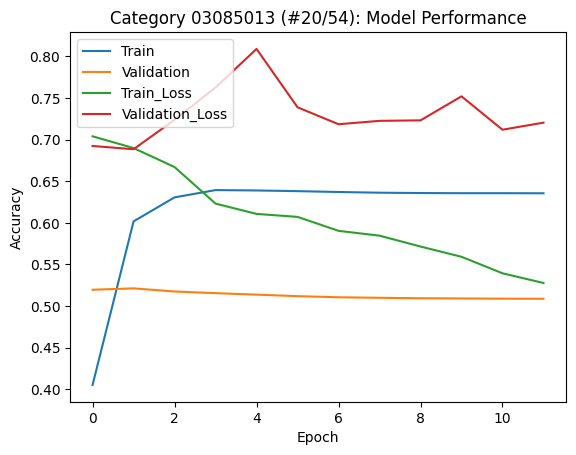

Starting training model for category #21/54: 03207941
x_train shape: (74, 128, 128, 1)
x_test shape: (19, 128, 128, 1)
y_train shape: (74, 32, 32, 32, 1)
y_test shape: (19, 32, 32, 32, 1)
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.9335 - accuracy: 0.6198
Epoch 1: val_accuracy improved from -inf to 0.68405, saving model to models/1x128x32\03207941.keras
2/2 [==============================] - 22s 22s/step - loss: 0.9335 - accuracy: 0.6198 - val_loss: 0.5920 - val_accuracy: 0.6840
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6118 - accuracy: 0.6616
Epoch 2: val_accuracy did not improve from 0.68405
2/2 [==============================] - 1s 151ms/step - loss: 0.6118 - accuracy: 0.6616 - val_loss: 0.6169 - val_accuracy: 0.6738
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.6219 - accuracy: 0.6587
Epoch 3: val_accuracy improved from 0.68405 to 0.68627, saving model to models/1x128x32\03207941.keras
2/2 [=================

INFO:tensorflow:Assets written to: ram://82eb1c84-ee50-4bf8-9221-3d8abbe826ee/assets


INFO:tensorflow:Assets written to: ram://82eb1c84-ee50-4bf8-9221-3d8abbe826ee/assets


Evaluating best model on category 03207941, input: 128, output: 32.
1/1 [==============================] - 1s 512ms/step - loss: 0.5036 - accuracy: 0.7807
Test Loss: 0.503555178642273, Test Accuracy: 0.7807119488716125


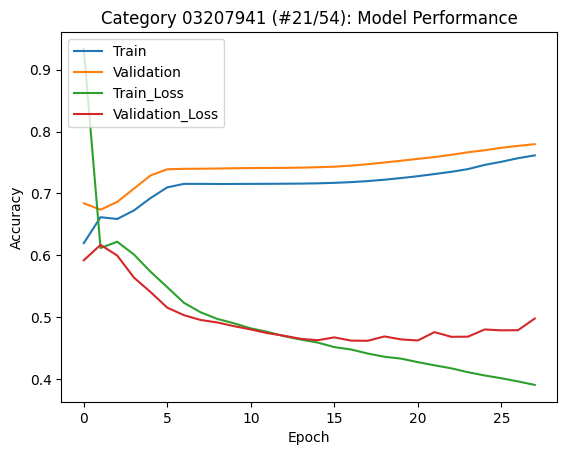

Starting training model for category #22/54: 03211117
x_train shape: (874, 128, 128, 1)
x_test shape: (219, 128, 128, 1)
y_train shape: (874, 32, 32, 32, 1)
y_test shape: (219, 32, 32, 32, 1)
Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.6030 - accuracy: 0.6857
Epoch 1: val_accuracy improved from -inf to 0.70864, saving model to models/1x128x32\03211117.keras
22/22 [==============================] - 26s 1s/step - loss: 0.6030 - accuracy: 0.6857 - val_loss: 0.5638 - val_accuracy: 0.7086
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.5293 - accuracy: 0.7178
Epoch 2: val_accuracy improved from 0.70864 to 0.70878, saving model to models/1x128x32\03211117.keras
22/22 [==============================] - 24s 1s/step - loss: 0.5293 - accuracy: 0.7178 - val_loss: 0.5380 - val_accuracy: 0.7088
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.4953 - accuracy: 0.7183
Epoch 3: val_accuracy improved from 0.70878 to 0.71036, saving

INFO:tensorflow:Assets written to: ram://2daf6415-7c65-45b6-a2de-280c2139ada4/assets


INFO:tensorflow:Assets written to: ram://2daf6415-7c65-45b6-a2de-280c2139ada4/assets


Evaluating best model on category 03211117, input: 128, output: 32.
7/7 [==============================] - 5s 488ms/step - loss: 0.5586 - accuracy: 0.7190
Test Loss: 0.5586103200912476, Test Accuracy: 0.7189956903457642


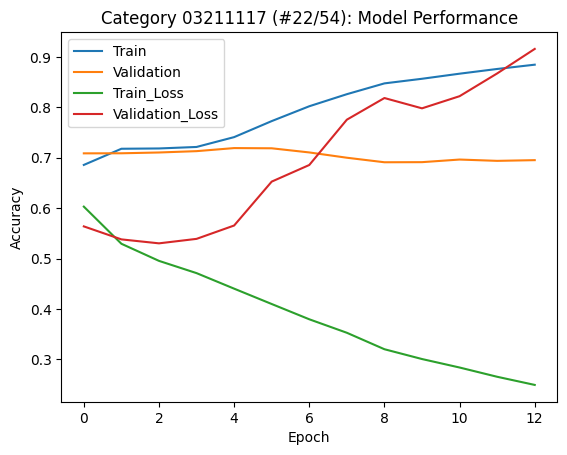

Starting training model for category #23/54: 03261776
x_train shape: (58, 128, 128, 1)
x_test shape: (15, 128, 128, 1)
y_train shape: (58, 32, 32, 32, 1)
y_test shape: (15, 32, 32, 32, 1)
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.6461 - accuracy: 0.6263
Epoch 1: val_accuracy improved from -inf to 0.82415, saving model to models/1x128x32\03261776.keras
2/2 [==============================] - 24s 23s/step - loss: 0.6461 - accuracy: 0.6263 - val_loss: 0.4775 - val_accuracy: 0.8241
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.4429 - accuracy: 0.8517
Epoch 2: val_accuracy improved from 0.82415 to 0.83347, saving model to models/1x128x32\03261776.keras
2/2 [==============================] - 20s 20s/step - loss: 0.4429 - accuracy: 0.8517 - val_loss: 0.4381 - val_accuracy: 0.8335
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.3756 - accuracy: 0.8588
Epoch 3: val_accuracy improved from 0.83347 to 0.83423, saving model to mo

INFO:tensorflow:Assets written to: ram://fdba3a80-63ea-4976-9798-ec1303850e11/assets


INFO:tensorflow:Assets written to: ram://fdba3a80-63ea-4976-9798-ec1303850e11/assets


Evaluating best model on category 03261776, input: 128, output: 32.
1/1 [==============================] - 0s 469ms/step - loss: 0.3699 - accuracy: 0.8743
Test Loss: 0.3699471652507782, Test Accuracy: 0.874310314655304


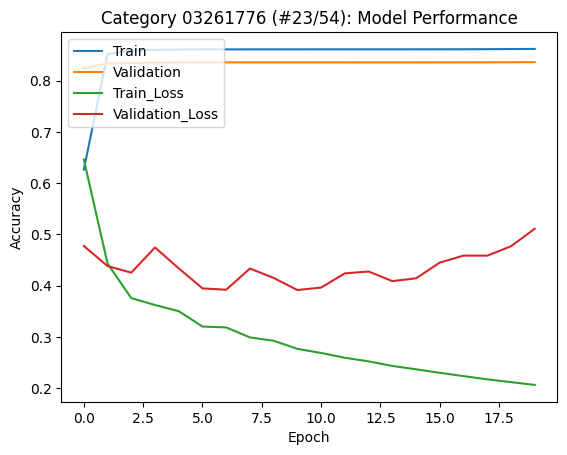

Starting training model for category #24/54: 03325088
x_train shape: (595, 128, 128, 1)
x_test shape: (149, 128, 128, 1)
y_train shape: (595, 32, 32, 32, 1)
y_test shape: (149, 32, 32, 32, 1)
Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.4377 - accuracy: 0.8330
Epoch 1: val_accuracy improved from -inf to 0.88998, saving model to models/1x128x32\03325088.keras
15/15 [==============================] - 24s 2s/step - loss: 0.4377 - accuracy: 0.8330 - val_loss: 0.3173 - val_accuracy: 0.8900
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.8946
Epoch 2: val_accuracy improved from 0.88998 to 0.89006, saving model to models/1x128x32\03325088.keras
15/15 [==============================] - 26s 2s/step - loss: 0.2869 - accuracy: 0.8946 - val_loss: 0.2850 - val_accuracy: 0.8901
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.8946
Epoch 3: val_accuracy did not improve from 0.89006
15/15 [====

INFO:tensorflow:Assets written to: ram://b116ae72-64ea-401e-9697-4237cc59f1cd/assets


INFO:tensorflow:Assets written to: ram://b116ae72-64ea-401e-9697-4237cc59f1cd/assets


Evaluating best model on category 03325088, input: 128, output: 32.


In [ ]:
train_models_all_categories(categories[12:],
                            input_shape=(128, 128, 1),
                            output_shape=(32, 32, 32, 1),
                            images_per_voxel=1,
                            test_size=0.2,
                            validation_split=0.2,
                            initial_cat_index=12)

Starting training model for category #24/54: 03325088
x_train shape: (595, 128, 128, 1)
x_test shape: (149, 128, 128, 1)
y_train shape: (595, 32, 32, 32, 1)
y_test shape: (149, 32, 32, 32, 1)
Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.4885 - accuracy: 0.8052
Epoch 1: val_accuracy improved from -inf to 0.89777, saving model to models/1x128x32\03325088.keras
15/15 [==============================] - 31s 2s/step - loss: 0.4885 - accuracy: 0.8052 - val_loss: 0.3171 - val_accuracy: 0.8978
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 0.2972 - accuracy: 0.8935
Epoch 2: val_accuracy improved from 0.89777 to 0.89784, saving model to models/1x128x32\03325088.keras
15/15 [==============================] - 25s 2s/step - loss: 0.2972 - accuracy: 0.8935 - val_loss: 0.2780 - val_accuracy: 0.8978
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.2626 - accuracy: 0.8935
Epoch 3: val_accuracy did not improve from 0.89784
15/15 [====

INFO:tensorflow:Assets written to: ram://18e5bc45-d14e-4749-99a8-7a3a3e20b983/assets


INFO:tensorflow:Assets written to: ram://18e5bc45-d14e-4749-99a8-7a3a3e20b983/assets


Evaluating best model on category 03325088, input: 128, output: 32.
5/5 [==============================] - 3s 433ms/step - loss: 0.3130 - accuracy: 0.8919
Test Loss: 0.31303858757019043, Test Accuracy: 0.8919470906257629


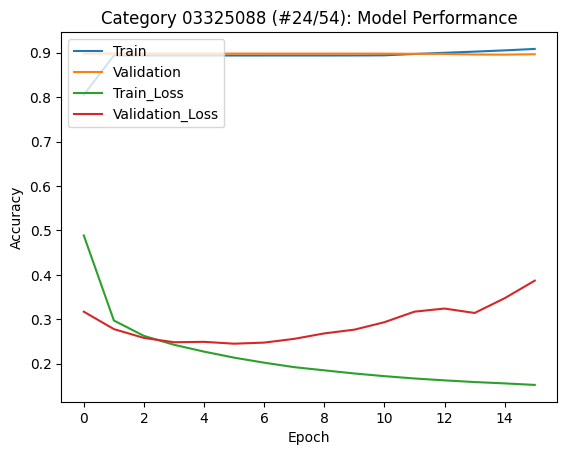

Starting training model for category #25/54: 03337140
x_train shape: (238, 128, 128, 1)
x_test shape: (60, 128, 128, 1)
y_train shape: (238, 32, 32, 32, 1)
y_test shape: (60, 32, 32, 32, 1)
Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.7550 - accuracy: 0.5780
Epoch 1: val_accuracy improved from -inf to 0.53617, saving model to models/1x128x32\03337140.keras
6/6 [==============================] - 26s 5s/step - loss: 0.7550 - accuracy: 0.5780 - val_loss: 0.6887 - val_accuracy: 0.5362
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.5568
Epoch 2: val_accuracy improved from 0.53617 to 0.55300, saving model to models/1x128x32\03337140.keras
6/6 [==============================] - 21s 4s/step - loss: 0.6867 - accuracy: 0.5568 - val_loss: 0.6845 - val_accuracy: 0.5530
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.5848
Epoch 3: val_accuracy improved from 0.55300 to 0.59079, saving model to mo

INFO:tensorflow:Assets written to: ram://ddddc3cd-12df-498d-871f-5c3e209df267/assets


INFO:tensorflow:Assets written to: ram://ddddc3cd-12df-498d-871f-5c3e209df267/assets


Evaluating best model on category 03337140, input: 128, output: 32.
2/2 [==============================] - 1s 416ms/step - loss: 0.6345 - accuracy: 0.7137
Test Loss: 0.6344980597496033, Test Accuracy: 0.7136738896369934


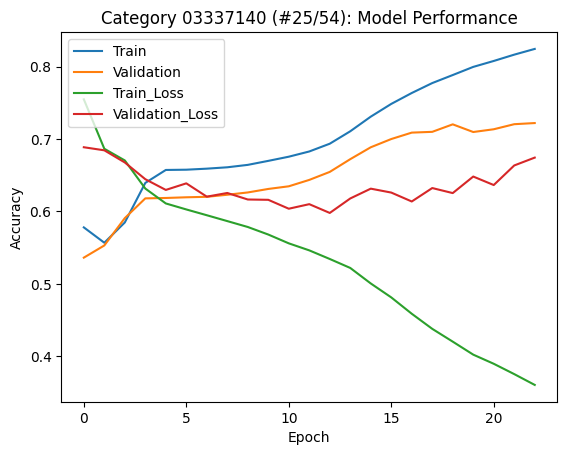

Starting training model for category #26/54: 03467517
x_train shape: (637, 128, 128, 1)
x_test shape: (160, 128, 128, 1)
y_train shape: (637, 32, 32, 32, 1)
y_test shape: (160, 32, 32, 32, 1)
Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.5210 - accuracy: 0.7002
Epoch 1: val_accuracy improved from -inf to 0.72077, saving model to models/1x128x32\03467517.keras
16/16 [==============================] - 23s 1s/step - loss: 0.5210 - accuracy: 0.7002 - val_loss: 0.4320 - val_accuracy: 0.7208
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.7297
Epoch 2: val_accuracy improved from 0.72077 to 0.72421, saving model to models/1x128x32\03467517.keras
16/16 [==============================] - 24s 2s/step - loss: 0.4280 - accuracy: 0.7297 - val_loss: 0.4124 - val_accuracy: 0.7242
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.4092 - accuracy: 0.7427
Epoch 3: val_accuracy improved from 0.72421 to 0.76445, saving

INFO:tensorflow:Assets written to: ram://fa3ee204-b050-4daf-9b80-2ec6c0a3988e/assets


INFO:tensorflow:Assets written to: ram://fa3ee204-b050-4daf-9b80-2ec6c0a3988e/assets


Evaluating best model on category 03467517, input: 128, output: 32.
5/5 [==============================] - 3s 470ms/step - loss: 0.5607 - accuracy: 0.8350
Test Loss: 0.5607193112373352, Test Accuracy: 0.8350288271903992


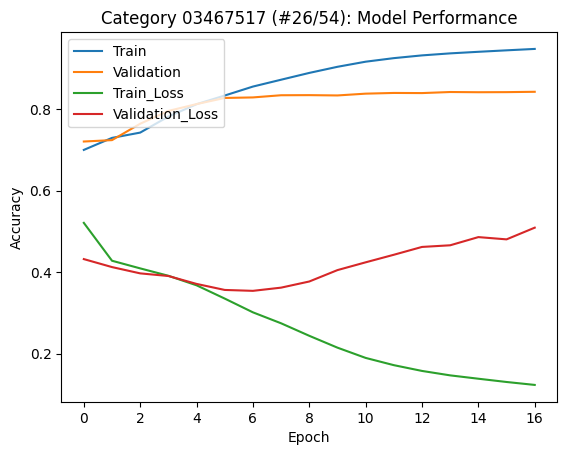

Starting training model for category #27/54: 03513137
x_train shape: (129, 128, 128, 1)
x_test shape: (33, 128, 128, 1)
y_train shape: (129, 32, 32, 32, 1)
y_test shape: (33, 32, 32, 32, 1)
Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 0.6554 - accuracy: 0.6293
Epoch 1: val_accuracy improved from -inf to 0.81163, saving model to models/1x128x32\03513137.keras
4/4 [==============================] - 24s 8s/step - loss: 0.6554 - accuracy: 0.6293 - val_loss: 0.5207 - val_accuracy: 0.8116
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 0.4937 - accuracy: 0.8291
Epoch 2: val_accuracy improved from 0.81163 to 0.82090, saving model to models/1x128x32\03513137.keras
4/4 [==============================] - 27s 9s/step - loss: 0.4937 - accuracy: 0.8291 - val_loss: 0.4888 - val_accuracy: 0.8209
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 0.4516 - accuracy: 0.8349
Epoch 3: val_accuracy improved from 0.82090 to 0.82149, saving model to mo

INFO:tensorflow:Assets written to: ram://0f8ea0b5-502d-4e1e-ba27-484df9380025/assets


INFO:tensorflow:Assets written to: ram://0f8ea0b5-502d-4e1e-ba27-484df9380025/assets


Evaluating best model on category 03513137, input: 128, output: 32.
2/2 [==============================] - 1s 202ms/step - loss: 0.4321 - accuracy: 0.8320
Test Loss: 0.432102233171463, Test Accuracy: 0.8319628238677979


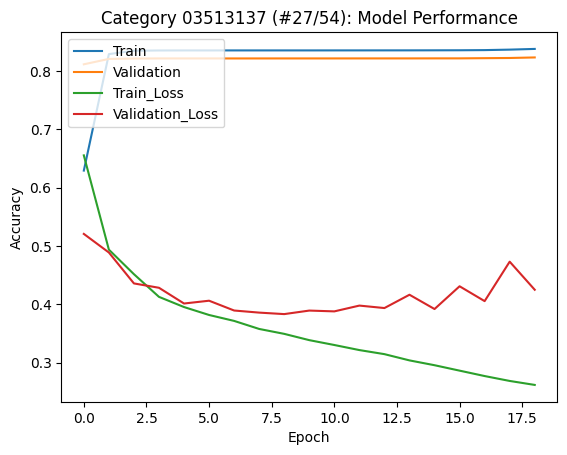

Starting training model for category #28/54: 03593526
x_train shape: (476, 128, 128, 1)
x_test shape: (120, 128, 128, 1)
y_train shape: (476, 32, 32, 32, 1)
y_test shape: (120, 32, 32, 32, 1)
Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.7072
Epoch 1: val_accuracy improved from -inf to 0.79612, saving model to models/1x128x32\03593526.keras
12/12 [==============================] - 27s 2s/step - loss: 0.5989 - accuracy: 0.7072 - val_loss: 0.5045 - val_accuracy: 0.7961
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.4702 - accuracy: 0.7985
Epoch 2: val_accuracy improved from 0.79612 to 0.79658, saving model to models/1x128x32\03593526.keras
12/12 [==============================] - 21s 2s/step - loss: 0.4702 - accuracy: 0.7985 - val_loss: 0.4433 - val_accuracy: 0.7966
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.4244 - accuracy: 0.7986
Epoch 3: val_accuracy improved from 0.79658 to 0.79659, saving

INFO:tensorflow:Assets written to: ram://7d2f9558-3b0d-4b9f-86be-953c27d74d93/assets


INFO:tensorflow:Assets written to: ram://7d2f9558-3b0d-4b9f-86be-953c27d74d93/assets


Evaluating best model on category 03593526, input: 128, output: 32.
4/4 [==============================] - 2s 463ms/step - loss: 0.4826 - accuracy: 0.8036
Test Loss: 0.4825593829154968, Test Accuracy: 0.803594708442688


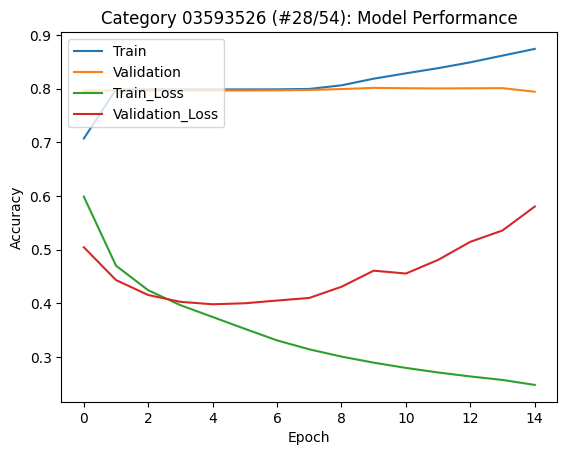

Starting training model for category #29/54: 03624134
x_train shape: (339, 128, 128, 1)
x_test shape: (85, 128, 128, 1)
y_train shape: (339, 32, 32, 32, 1)
y_test shape: (85, 32, 32, 32, 1)
Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.6250
Epoch 1: val_accuracy improved from -inf to 0.64008, saving model to models/1x128x32\03624134.keras
9/9 [==============================] - 22s 3s/step - loss: 0.6694 - accuracy: 0.6250 - val_loss: 0.6229 - val_accuracy: 0.6401
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.5753 - accuracy: 0.6869
Epoch 2: val_accuracy improved from 0.64008 to 0.64246, saving model to models/1x128x32\03624134.keras
9/9 [==============================] - 23s 3s/step - loss: 0.5753 - accuracy: 0.6869 - val_loss: 0.5786 - val_accuracy: 0.6425
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.5482 - accuracy: 0.6879
Epoch 3: val_accuracy improved from 0.64246 to 0.64256, saving model to mo

INFO:tensorflow:Assets written to: ram://dd09effd-2a1f-4444-936c-17b88db488d7/assets


INFO:tensorflow:Assets written to: ram://dd09effd-2a1f-4444-936c-17b88db488d7/assets


Evaluating best model on category 03624134, input: 128, output: 32.
3/3 [==============================] - 1s 410ms/step - loss: 0.5134 - accuracy: 0.7494
Test Loss: 0.5133951306343079, Test Accuracy: 0.7493756413459778


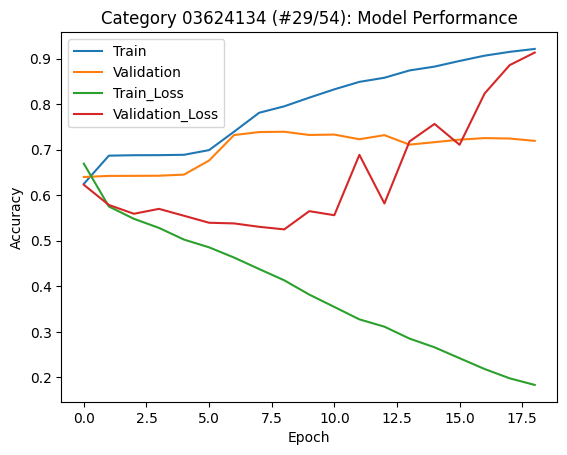

Starting training model for category #30/54: 03636649
x_train shape: (1854, 128, 128, 1)
x_test shape: (464, 128, 128, 1)
y_train shape: (1854, 32, 32, 32, 1)
y_test shape: (464, 32, 32, 32, 1)
Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 0.3634 - accuracy: 0.8588
Epoch 1: val_accuracy improved from -inf to 0.86557, saving model to models/1x128x32\03636649.keras
47/47 [==============================] - 29s 622ms/step - loss: 0.3634 - accuracy: 0.8588 - val_loss: 0.3291 - val_accuracy: 0.8656
Epoch 2/100
47/47 [==============================] - ETA: 0s - loss: 0.3056 - accuracy: 0.8681
Epoch 2: val_accuracy did not improve from 0.86557
47/47 [==============================] - 6s 115ms/step - loss: 0.3056 - accuracy: 0.8681 - val_loss: 0.3161 - val_accuracy: 0.8656
Epoch 3/100
47/47 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.8681
Epoch 3: val_accuracy did not improve from 0.86557
47/47 [==============================] - 5s 115ms/step -

INFO:tensorflow:Assets written to: ram://09e2d89c-70e3-4e9b-887e-f928af55f0fb/assets


INFO:tensorflow:Assets written to: ram://09e2d89c-70e3-4e9b-887e-f928af55f0fb/assets


Evaluating best model on category 03636649, input: 128, output: 32.
15/15 [==============================] - 7s 468ms/step - loss: 0.3342 - accuracy: 0.8716
Test Loss: 0.334229975938797, Test Accuracy: 0.8715722560882568


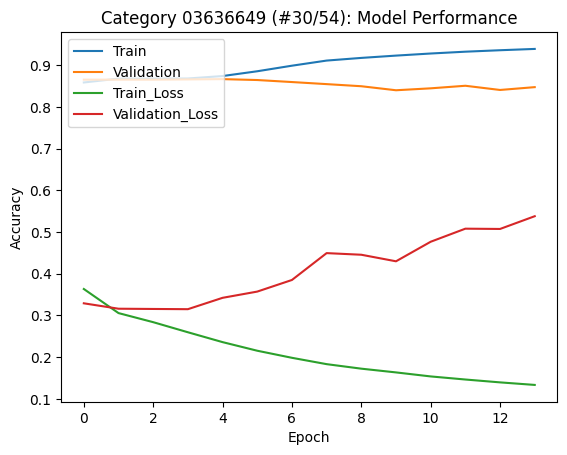

Starting training model for category #31/54: 03642806
x_train shape: (368, 128, 128, 1)
x_test shape: (92, 128, 128, 1)
y_train shape: (368, 32, 32, 32, 1)
y_test shape: (92, 32, 32, 32, 1)
Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.4682 - accuracy: 0.7362
Epoch 1: val_accuracy improved from -inf to 0.83423, saving model to models/1x128x32\03642806.keras
10/10 [==============================] - 25s 3s/step - loss: 0.4682 - accuracy: 0.7362 - val_loss: 0.3740 - val_accuracy: 0.8342
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.8441
Epoch 2: val_accuracy improved from 0.83423 to 0.83499, saving model to models/1x128x32\03642806.keras
10/10 [==============================] - 21s 2s/step - loss: 0.3003 - accuracy: 0.8441 - val_loss: 0.2898 - val_accuracy: 0.8350
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.2589 - accuracy: 0.8446
Epoch 3: val_accuracy improved from 0.83499 to 0.83507, saving m

INFO:tensorflow:Assets written to: ram://4f7adc73-0045-4a83-b6ee-14499976ebdd/assets


INFO:tensorflow:Assets written to: ram://4f7adc73-0045-4a83-b6ee-14499976ebdd/assets


Evaluating best model on category 03642806, input: 128, output: 32.
3/3 [==============================] - 2s 427ms/step - loss: 0.2624 - accuracy: 0.8957
Test Loss: 0.2624111473560333, Test Accuracy: 0.8956584334373474


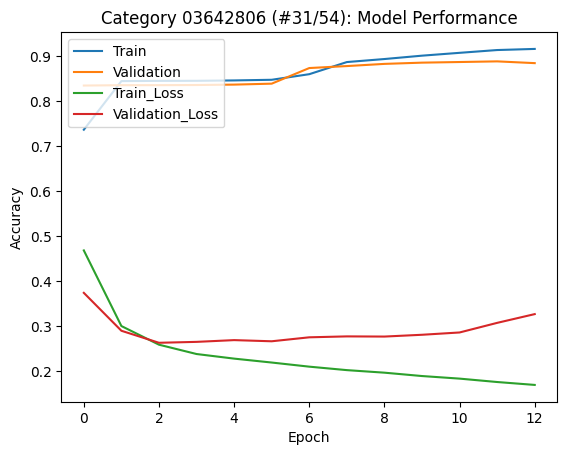

Starting training model for category #32/54: 03691459
x_train shape: (1277, 128, 128, 1)
x_test shape: (320, 128, 128, 1)
y_train shape: (1277, 32, 32, 32, 1)
y_test shape: (320, 32, 32, 32, 1)
Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.6610
Epoch 1: val_accuracy improved from -inf to 0.68328, saving model to models/1x128x32\03691459.keras
32/32 [==============================] - 25s 790ms/step - loss: 0.6526 - accuracy: 0.6610 - val_loss: 0.5973 - val_accuracy: 0.6833
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 0.5902 - accuracy: 0.6870
Epoch 2: val_accuracy improved from 0.68328 to 0.68334, saving model to models/1x128x32\03691459.keras
32/32 [==============================] - 23s 727ms/step - loss: 0.5902 - accuracy: 0.6870 - val_loss: 0.5826 - val_accuracy: 0.6833
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 0.5746 - accuracy: 0.6878
Epoch 3: val_accuracy improved from 0.68334 to 0.68568

INFO:tensorflow:Assets written to: ram://1edcb584-628a-4dc4-81e5-23346d45543d/assets


INFO:tensorflow:Assets written to: ram://1edcb584-628a-4dc4-81e5-23346d45543d/assets


Evaluating best model on category 03691459, input: 128, output: 32.
10/10 [==============================] - 5s 453ms/step - loss: 0.5753 - accuracy: 0.7137
Test Loss: 0.5752596855163574, Test Accuracy: 0.7137222290039062


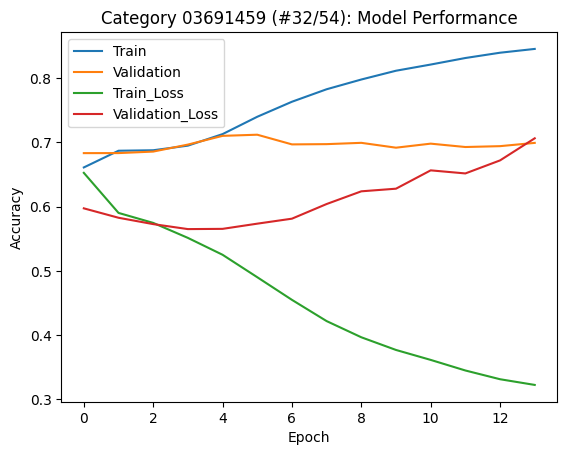

Starting training model for category #33/54: 03710193
x_train shape: (75, 128, 128, 1)
x_test shape: (19, 128, 128, 1)
y_train shape: (75, 32, 32, 32, 1)
y_test shape: (19, 32, 32, 32, 1)
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.4989
Epoch 1: val_accuracy improved from -inf to 0.69326, saving model to models/1x128x32\03710193.keras
2/2 [==============================] - 22s 21s/step - loss: 0.6963 - accuracy: 0.4989 - val_loss: 0.6661 - val_accuracy: 0.6933
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.7285
Epoch 2: val_accuracy improved from 0.69326 to 0.77921, saving model to models/1x128x32\03710193.keras
2/2 [==============================] - 24s 23s/step - loss: 0.6279 - accuracy: 0.7285 - val_loss: 0.7634 - val_accuracy: 0.7792
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.7904
Epoch 3: val_accuracy improved from 0.77921 to 0.78643, saving model to mo

INFO:tensorflow:Assets written to: ram://069ca6f0-e30d-48ce-b4bd-40c06c7ab2f9/assets


INFO:tensorflow:Assets written to: ram://069ca6f0-e30d-48ce-b4bd-40c06c7ab2f9/assets


Evaluating best model on category 03710193, input: 128, output: 32.
1/1 [==============================] - 8s 8s/step - loss: 0.4668 - accuracy: 0.7772
Test Loss: 0.4668165147304535, Test Accuracy: 0.7771686911582947


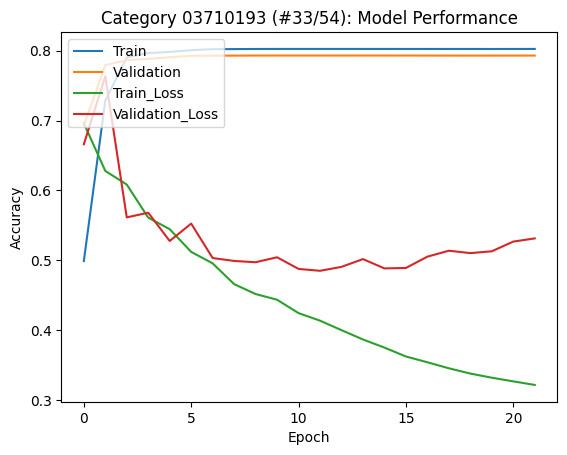

Starting training model for category #34/54: 03759954
x_train shape: (53, 128, 128, 1)
x_test shape: (14, 128, 128, 1)
y_train shape: (53, 32, 32, 32, 1)
y_test shape: (14, 32, 32, 32, 1)
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.7099 - accuracy: 0.3031
Epoch 1: val_accuracy improved from -inf to 0.79461, saving model to models/1x128x32\03759954.keras
2/2 [==============================] - 24s 22s/step - loss: 0.7099 - accuracy: 0.3031 - val_loss: 0.6910 - val_accuracy: 0.7946
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.7567
Epoch 2: val_accuracy improved from 0.79461 to 0.83723, saving model to models/1x128x32\03759954.keras
2/2 [==============================] - 24s 24s/step - loss: 0.6907 - accuracy: 0.7567 - val_loss: 0.6828 - val_accuracy: 0.8372
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.7929
Epoch 3: val_accuracy improved from 0.83723 to 0.84874, saving model to mo

INFO:tensorflow:Assets written to: ram://993b4688-9583-4ef6-9173-a6f7f8d4a1a2/assets


INFO:tensorflow:Assets written to: ram://993b4688-9583-4ef6-9173-a6f7f8d4a1a2/assets


Evaluating best model on category 03759954, input: 128, output: 32.
1/1 [==============================] - 1s 515ms/step - loss: 0.3621 - accuracy: 0.8502
Test Loss: 0.36208376288414, Test Accuracy: 0.8501957654953003


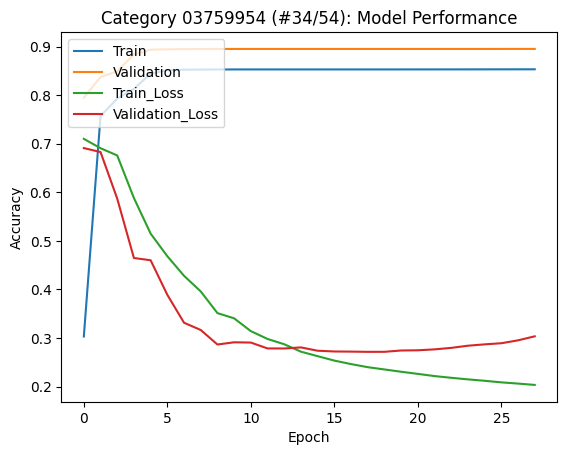

Starting training model for category #35/54: 03761084
x_train shape: (121, 128, 128, 1)
x_test shape: (31, 128, 128, 1)
y_train shape: (121, 32, 32, 32, 1)
y_test shape: (31, 32, 32, 32, 1)
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.6620 - accuracy: 0.5891
Epoch 1: val_accuracy improved from -inf to 0.71207, saving model to models/1x128x32\03761084.keras
3/3 [==============================] - 23s 11s/step - loss: 0.6620 - accuracy: 0.5891 - val_loss: 0.5702 - val_accuracy: 0.7121
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.5709 - accuracy: 0.7000
Epoch 2: val_accuracy improved from 0.71207 to 0.72721, saving model to models/1x128x32\03761084.keras
3/3 [==============================] - 20s 10s/step - loss: 0.5709 - accuracy: 0.7000 - val_loss: 0.5380 - val_accuracy: 0.7272
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.5374 - accuracy: 0.7041
Epoch 3: val_accuracy improved from 0.72721 to 0.72857, saving model to 

INFO:tensorflow:Assets written to: ram://4356b63e-47f2-450d-a8f8-096ab5f71cfb/assets


INFO:tensorflow:Assets written to: ram://4356b63e-47f2-450d-a8f8-096ab5f71cfb/assets


Evaluating best model on category 03761084, input: 128, output: 32.


MemoryError: Unable to allocate 1.00 GiB for an array with shape (65536, 4096) and data type float32

In [12]:
train_models_all_categories(categories[23:],
                            input_shape=(128, 128, 1),
                            output_shape=(32, 32, 32, 1),
                            images_per_voxel=1,
                            test_size=0.2,
                            validation_split=0.2,
                            initial_cat_index=23)

Starting training model for category #31/54: 03642806
x_train shape: (368, 128, 128, 1)
x_test shape: (92, 128, 128, 1)
y_train shape: (368, 32, 32, 32, 1)
y_test shape: (92, 32, 32, 32, 1)
Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.7714
Epoch 1: val_accuracy improved from -inf to 0.83409, saving model to models/1x128x32\03642806.keras
10/10 [==============================] - 38s 3s/step - loss: 0.4255 - accuracy: 0.7714 - val_loss: 0.3332 - val_accuracy: 0.8341
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.2679 - accuracy: 0.8473
Epoch 2: val_accuracy improved from 0.83409 to 0.83541, saving model to models/1x128x32\03642806.keras
10/10 [==============================] - 20s 2s/step - loss: 0.2679 - accuracy: 0.8473 - val_loss: 0.2897 - val_accuracy: 0.8354
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.8483
Epoch 3: val_accuracy improved from 0.83541 to 0.83617, saving m

INFO:tensorflow:Assets written to: ram://96c549ec-8834-46ea-803a-95be1a037d78/assets


INFO:tensorflow:Assets written to: ram://96c549ec-8834-46ea-803a-95be1a037d78/assets


Evaluating best model on category 03642806, input: 128, output: 32.
3/3 [==============================] - 2s 514ms/step - loss: 0.2731 - accuracy: 0.8924
Test Loss: 0.2731381356716156, Test Accuracy: 0.892360508441925


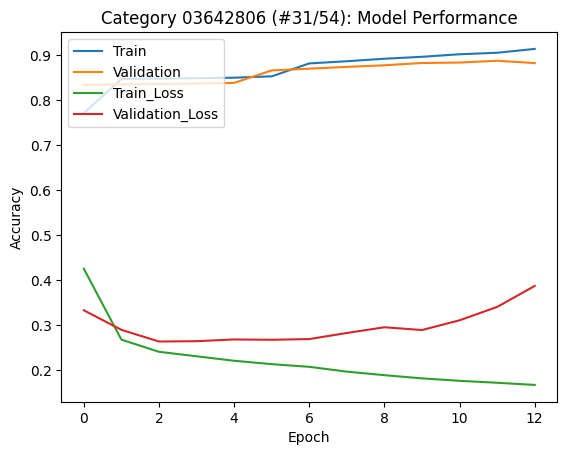

Starting training model for category #32/54: 03691459
x_train shape: (1277, 128, 128, 1)
x_test shape: (320, 128, 128, 1)
y_train shape: (1277, 32, 32, 32, 1)
y_test shape: (320, 32, 32, 32, 1)
Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.6736
Epoch 1: val_accuracy improved from -inf to 0.68025, saving model to models/1x128x32\03691459.keras
32/32 [==============================] - 26s 811ms/step - loss: 0.6166 - accuracy: 0.6736 - val_loss: 0.5839 - val_accuracy: 0.6803
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.6864
Epoch 2: val_accuracy improved from 0.68025 to 0.68814, saving model to models/1x128x32\03691459.keras
32/32 [==============================] - 23s 726ms/step - loss: 0.5801 - accuracy: 0.6864 - val_loss: 0.5641 - val_accuracy: 0.6881
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.7054
Epoch 3: val_accuracy improved from 0.68814 to 0.71411

INFO:tensorflow:Assets written to: ram://d0e8532e-7e20-4474-9906-f6fcbcd01b45/assets


INFO:tensorflow:Assets written to: ram://d0e8532e-7e20-4474-9906-f6fcbcd01b45/assets


Evaluating best model on category 03691459, input: 128, output: 32.
10/10 [==============================] - 5s 465ms/step - loss: 0.6244 - accuracy: 0.7215
Test Loss: 0.6244484186172485, Test Accuracy: 0.721530556678772


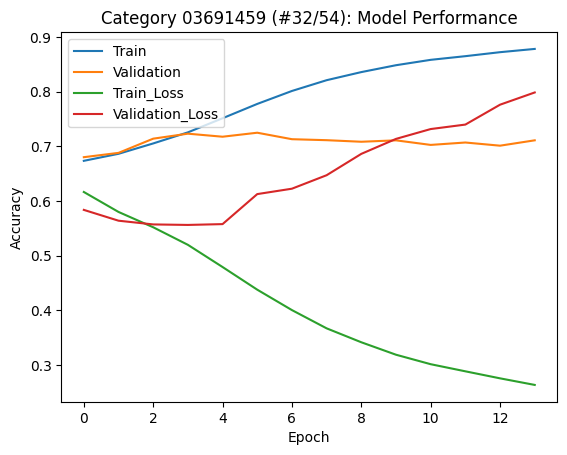

Starting training model for category #33/54: 03710193
x_train shape: (75, 128, 128, 1)
x_test shape: (19, 128, 128, 1)
y_train shape: (75, 32, 32, 32, 1)
y_test shape: (19, 32, 32, 32, 1)
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.4840
Epoch 1: val_accuracy improved from -inf to 0.68138, saving model to models/1x128x32\03710193.keras
2/2 [==============================] - 21s 20s/step - loss: 0.6963 - accuracy: 0.4840 - val_loss: 0.6606 - val_accuracy: 0.6814
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6304 - accuracy: 0.7191
Epoch 2: val_accuracy improved from 0.68138 to 0.76709, saving model to models/1x128x32\03710193.keras
2/2 [==============================] - 24s 23s/step - loss: 0.6304 - accuracy: 0.7191 - val_loss: 0.6242 - val_accuracy: 0.7671
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.5866 - accuracy: 0.7879
Epoch 3: val_accuracy improved from 0.76709 to 0.77929, saving model to mo

INFO:tensorflow:Assets written to: ram://9d1fef80-96e6-4bf0-9d0b-586236e494db/assets


INFO:tensorflow:Assets written to: ram://9d1fef80-96e6-4bf0-9d0b-586236e494db/assets


Evaluating best model on category 03710193, input: 128, output: 32.
1/1 [==============================] - 1s 535ms/step - loss: 0.4648 - accuracy: 0.7900
Test Loss: 0.4647737443447113, Test Accuracy: 0.7899699807167053


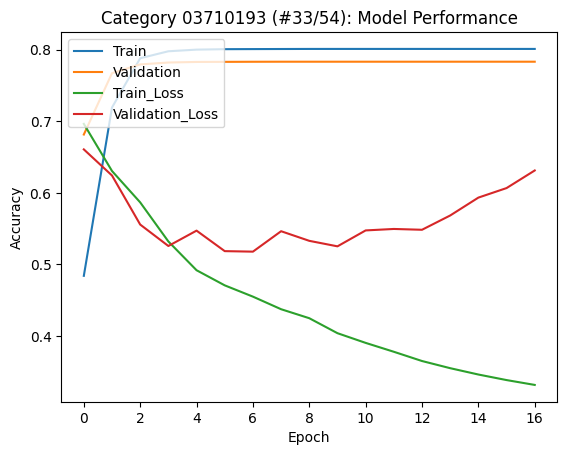

Starting training model for category #34/54: 03759954
x_train shape: (53, 128, 128, 1)
x_test shape: (14, 128, 128, 1)
y_train shape: (53, 32, 32, 32, 1)
y_test shape: (14, 32, 32, 32, 1)
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.3716
Epoch 1: val_accuracy improved from -inf to 0.72501, saving model to models/1x128x32\03759954.keras
2/2 [==============================] - 21s 20s/step - loss: 0.7071 - accuracy: 0.3716 - val_loss: 0.6870 - val_accuracy: 0.7250
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.8014
Epoch 2: val_accuracy improved from 0.72501 to 0.76529, saving model to models/1x128x32\03759954.keras
2/2 [==============================] - 24s 23s/step - loss: 0.6777 - accuracy: 0.8014 - val_loss: 0.6280 - val_accuracy: 0.7653
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.8625
Epoch 3: val_accuracy improved from 0.76529 to 0.78047, saving model to mo

INFO:tensorflow:Assets written to: ram://746f96ab-6567-4973-8d84-0fa1c77ccf88/assets


INFO:tensorflow:Assets written to: ram://746f96ab-6567-4973-8d84-0fa1c77ccf88/assets


Evaluating best model on category 03759954, input: 128, output: 32.
1/1 [==============================] - 0s 441ms/step - loss: 0.4754 - accuracy: 0.8356
Test Loss: 0.47541555762290955, Test Accuracy: 0.8356475830078125


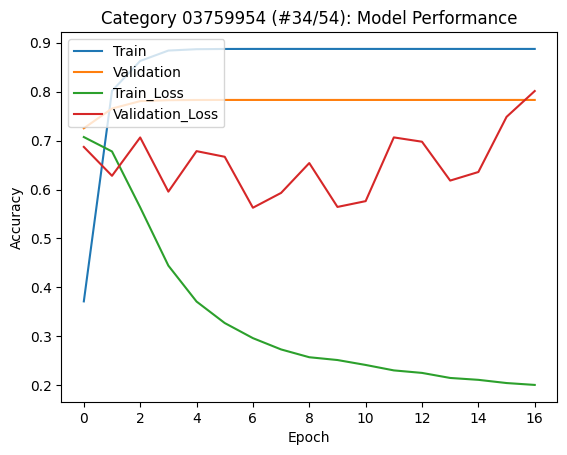

Starting training model for category #35/54: 03761084
x_train shape: (121, 128, 128, 1)
x_test shape: (31, 128, 128, 1)
y_train shape: (121, 32, 32, 32, 1)
y_test shape: (31, 32, 32, 32, 1)
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.9276 - accuracy: 0.6505
Epoch 1: val_accuracy improved from -inf to 0.61235, saving model to models/1x128x32\03761084.keras
3/3 [==============================] - 21s 10s/step - loss: 0.9276 - accuracy: 0.6505 - val_loss: 0.6526 - val_accuracy: 0.6124
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.6186
Epoch 2: val_accuracy did not improve from 0.61235
3/3 [==============================] - 1s 138ms/step - loss: 0.6559 - accuracy: 0.6186 - val_loss: 0.6698 - val_accuracy: 0.5952
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.6647 - accuracy: 0.6133
Epoch 3: val_accuracy did not improve from 0.61235
3/3 [==============================] - 0s 132ms/step - loss: 0.6647 - ac

INFO:tensorflow:Assets written to: ram://3c008f40-055f-4644-bc4d-60f4bb3d4ede/assets


INFO:tensorflow:Assets written to: ram://3c008f40-055f-4644-bc4d-60f4bb3d4ede/assets


Evaluating best model on category 03761084, input: 128, output: 32.
1/1 [==============================] - 1s 690ms/step - loss: 0.5613 - accuracy: 0.7499
Test Loss: 0.5613111257553101, Test Accuracy: 0.749945878982544


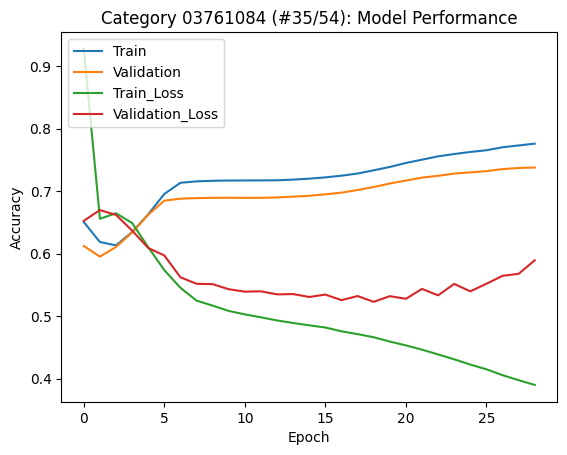

Starting training model for category #36/54: 03790512
x_train shape: (269, 128, 128, 1)
x_test shape: (68, 128, 128, 1)
y_train shape: (269, 32, 32, 32, 1)
y_test shape: (68, 32, 32, 32, 1)
Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.6220 - accuracy: 0.6626
Epoch 1: val_accuracy improved from -inf to 0.79656, saving model to models/1x128x32\03790512.keras
7/7 [==============================] - 22s 4s/step - loss: 0.6220 - accuracy: 0.6626 - val_loss: 0.4400 - val_accuracy: 0.7966
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.4118 - accuracy: 0.8028
Epoch 2: val_accuracy improved from 0.79656 to 0.80290, saving model to models/1x128x32\03790512.keras
7/7 [==============================] - 38s 6s/step - loss: 0.4118 - accuracy: 0.8028 - val_loss: 0.3751 - val_accuracy: 0.8029
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.3634 - accuracy: 0.8049
Epoch 3: val_accuracy improved from 0.80290 to 0.80346, saving model to mo

INFO:tensorflow:Assets written to: ram://447f7c79-b2a0-4753-a15c-fee3e344f4af/assets


INFO:tensorflow:Assets written to: ram://447f7c79-b2a0-4753-a15c-fee3e344f4af/assets


Evaluating best model on category 03790512, input: 128, output: 32.
3/3 [==============================] - 1s 319ms/step - loss: 0.4083 - accuracy: 0.8637
Test Loss: 0.4082549512386322, Test Accuracy: 0.8636788725852966


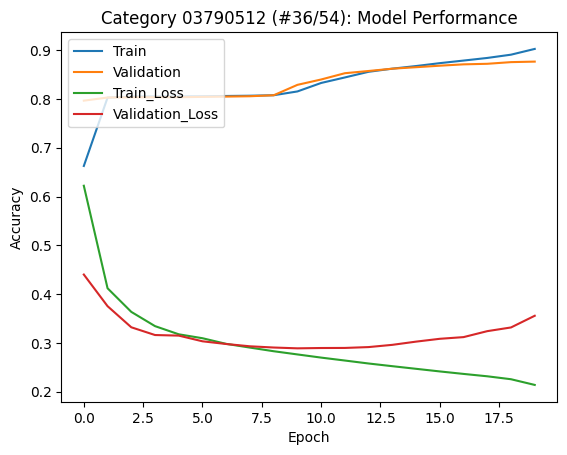

Starting training model for category #37/54: 03797390
x_train shape: (171, 128, 128, 1)
x_test shape: (43, 128, 128, 1)
y_train shape: (171, 32, 32, 32, 1)
y_test shape: (43, 32, 32, 32, 1)
Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.7918 - accuracy: 0.6606
Epoch 1: val_accuracy improved from -inf to 0.64344, saving model to models/1x128x32\03797390.keras
5/5 [==============================] - 21s 5s/step - loss: 0.7918 - accuracy: 0.6606 - val_loss: 0.6615 - val_accuracy: 0.6434
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.6505 - accuracy: 0.6666
Epoch 2: val_accuracy improved from 0.64344 to 0.73391, saving model to models/1x128x32\03797390.keras
5/5 [==============================] - 23s 6s/step - loss: 0.6505 - accuracy: 0.6666 - val_loss: 0.5998 - val_accuracy: 0.7339
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.7439
Epoch 3: val_accuracy improved from 0.73391 to 0.77076, saving model to mo

INFO:tensorflow:Assets written to: ram://c7741d04-c36e-41c6-9b3e-38f7bf340b48/assets


INFO:tensorflow:Assets written to: ram://c7741d04-c36e-41c6-9b3e-38f7bf340b48/assets


Evaluating best model on category 03797390, input: 128, output: 32.
2/2 [==============================] - 1s 285ms/step - loss: 0.4488 - accuracy: 0.8235
Test Loss: 0.4488421678543091, Test Accuracy: 0.8234877586364746


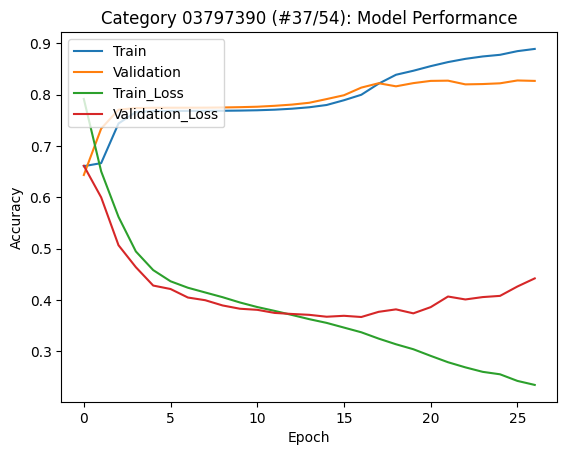

Starting training model for category #38/54: 03928116
x_train shape: (191, 128, 128, 1)
x_test shape: (48, 128, 128, 1)
y_train shape: (191, 32, 32, 32, 1)
y_test shape: (48, 32, 32, 32, 1)
Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.8722 - accuracy: 0.6788
Epoch 1: val_accuracy improved from -inf to 0.64832, saving model to models/1x128x32\03928116.keras
5/5 [==============================] - 26s 6s/step - loss: 0.8722 - accuracy: 0.6788 - val_loss: 0.6653 - val_accuracy: 0.6483
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.6667 - accuracy: 0.6398
Epoch 2: val_accuracy improved from 0.64832 to 0.65911, saving model to models/1x128x32\03928116.keras
5/5 [==============================] - 21s 5s/step - loss: 0.6667 - accuracy: 0.6398 - val_loss: 0.6591 - val_accuracy: 0.6591
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 0.6694
Epoch 3: val_accuracy improved from 0.65911 to 0.70367, saving model to mo

INFO:tensorflow:Assets written to: ram://877214ea-d922-4b32-831b-beef4de2d5ca/assets


INFO:tensorflow:Assets written to: ram://877214ea-d922-4b32-831b-beef4de2d5ca/assets


Evaluating best model on category 03928116, input: 128, output: 32.
2/2 [==============================] - 1s 263ms/step - loss: 0.5920 - accuracy: 0.7498
Test Loss: 0.5919514894485474, Test Accuracy: 0.74981689453125


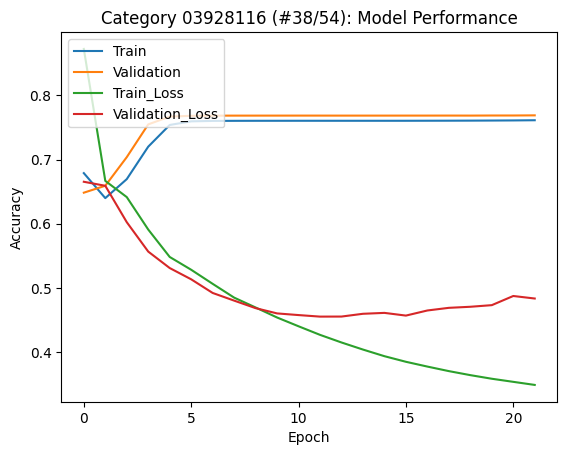

Starting training model for category #39/54: 03938244
x_train shape: (76, 128, 128, 1)
x_test shape: (20, 128, 128, 1)
y_train shape: (76, 32, 32, 32, 1)
y_test shape: (20, 32, 32, 32, 1)
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.3718
Epoch 1: val_accuracy improved from -inf to 0.63206, saving model to models/1x128x32\03938244.keras
2/2 [==============================] - 21s 20s/step - loss: 0.7137 - accuracy: 0.3718 - val_loss: 0.6909 - val_accuracy: 0.6321
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 0.6384
Epoch 2: val_accuracy improved from 0.63206 to 0.68954, saving model to models/1x128x32\03938244.keras
2/2 [==============================] - 22s 22s/step - loss: 0.6893 - accuracy: 0.6384 - val_loss: 0.6628 - val_accuracy: 0.6895
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.6418 - accuracy: 0.6828
Epoch 3: val_accuracy improved from 0.68954 to 0.73775, saving model to mo

INFO:tensorflow:Assets written to: ram://ba370fa9-9120-4fe0-9a72-db432b9c38df/assets


INFO:tensorflow:Assets written to: ram://ba370fa9-9120-4fe0-9a72-db432b9c38df/assets


Evaluating best model on category 03938244, input: 128, output: 32.
1/1 [==============================] - 1s 512ms/step - loss: 0.7914 - accuracy: 0.7700
Test Loss: 0.7914212346076965, Test Accuracy: 0.7699661254882812


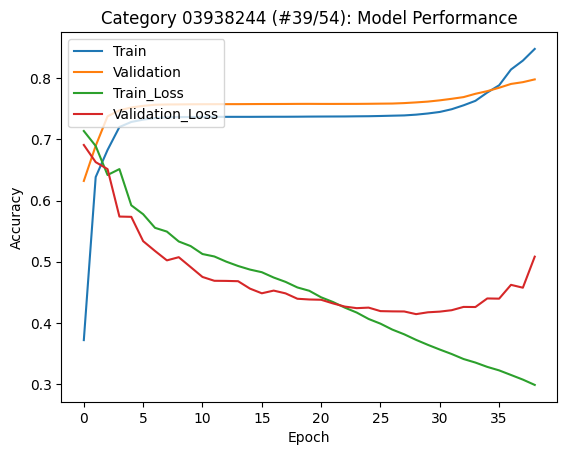

Starting training model for category #40/54: 03948459
x_train shape: (245, 128, 128, 1)
x_test shape: (62, 128, 128, 1)
y_train shape: (245, 32, 32, 32, 1)
y_test shape: (62, 32, 32, 32, 1)
Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.5851 - accuracy: 0.7016
Epoch 1: val_accuracy improved from -inf to 0.73237, saving model to models/1x128x32\03948459.keras
7/7 [==============================] - 23s 4s/step - loss: 0.5851 - accuracy: 0.7016 - val_loss: 0.5069 - val_accuracy: 0.7324
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.4743 - accuracy: 0.7341
Epoch 2: val_accuracy improved from 0.73237 to 0.73302, saving model to models/1x128x32\03948459.keras
7/7 [==============================] - 21s 3s/step - loss: 0.4743 - accuracy: 0.7341 - val_loss: 0.4587 - val_accuracy: 0.7330
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.4487 - accuracy: 0.7346
Epoch 3: val_accuracy improved from 0.73302 to 0.73315, saving model to mo

INFO:tensorflow:Assets written to: ram://83c15970-2ec9-449b-b01c-c6ad63bd09e4/assets


INFO:tensorflow:Assets written to: ram://83c15970-2ec9-449b-b01c-c6ad63bd09e4/assets


Evaluating best model on category 03948459, input: 128, output: 32.
2/2 [==============================] - 1s 435ms/step - loss: 0.4460 - accuracy: 0.8033
Test Loss: 0.4460046589374542, Test Accuracy: 0.8033407926559448


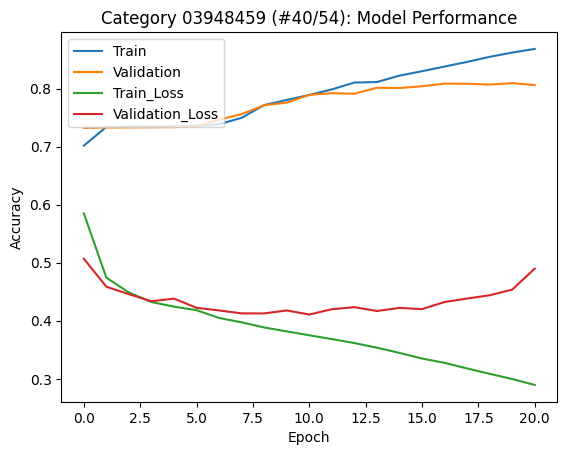

Starting training model for category #41/54: 03991062
x_train shape: (481, 128, 128, 1)
x_test shape: (121, 128, 128, 1)
y_train shape: (481, 32, 32, 32, 1)
y_test shape: (121, 32, 32, 32, 1)
Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.5718 - accuracy: 0.7510
Epoch 1: val_accuracy improved from -inf to 0.77808, saving model to models/1x128x32\03991062.keras
12/12 [==============================] - 25s 2s/step - loss: 0.5718 - accuracy: 0.7510 - val_loss: 0.4859 - val_accuracy: 0.7781
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.4547 - accuracy: 0.7909
Epoch 2: val_accuracy improved from 0.77808 to 0.77815, saving model to models/1x128x32\03991062.keras
12/12 [==============================] - 25s 2s/step - loss: 0.4547 - accuracy: 0.7909 - val_loss: 0.4447 - val_accuracy: 0.7781
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.7909
Epoch 3: val_accuracy did not improve from 0.77815
12/12 [====

INFO:tensorflow:Assets written to: ram://1d43ea5c-3137-4d4c-b956-5d2945536492/assets


INFO:tensorflow:Assets written to: ram://1d43ea5c-3137-4d4c-b956-5d2945536492/assets


Evaluating best model on category 03991062, input: 128, output: 32.


MemoryError: bad allocation

In [14]:
train_models_all_categories(categories[30:],
                            input_shape=(128, 128, 1),
                            output_shape=(32, 32, 32, 1),
                            images_per_voxel=1,
                            test_size=0.2,
                            validation_split=0.2,
                            initial_cat_index=30)

Starting training model for category #39/54: 03938244
x_train shape: (76, 128, 128, 1)
x_test shape: (20, 128, 128, 1)
y_train shape: (76, 32, 32, 32, 1)
y_test shape: (20, 32, 32, 32, 1)
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.7183 - accuracy: 0.6088 
Epoch 1: val_accuracy improved from -inf to 0.70495, saving model to models/1x128x32\03938244.keras
2/2 [==============================] - 40s 23s/step - loss: 0.7183 - accuracy: 0.6088 - val_loss: 0.6215 - val_accuracy: 0.7050
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6297 - accuracy: 0.6758
Epoch 2: val_accuracy improved from 0.70495 to 0.73927, saving model to models/1x128x32\03938244.keras
2/2 [==============================] - 20s 20s/step - loss: 0.6297 - accuracy: 0.6758 - val_loss: 0.5900 - val_accuracy: 0.7393
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.5999 - accuracy: 0.7027
Epoch 3: val_accuracy improved from 0.73927 to 0.76321, saving model to m

INFO:tensorflow:Assets written to: ram://d86efb32-df73-421c-8cc0-42ba69a26642/assets


INFO:tensorflow:Assets written to: ram://d86efb32-df73-421c-8cc0-42ba69a26642/assets


Evaluating best model on category 03938244, input: 128, output: 32.
1/1 [==============================] - 1s 1s/step - loss: 0.5275 - accuracy: 0.7527
Test Loss: 0.5274708271026611, Test Accuracy: 0.7527374029159546


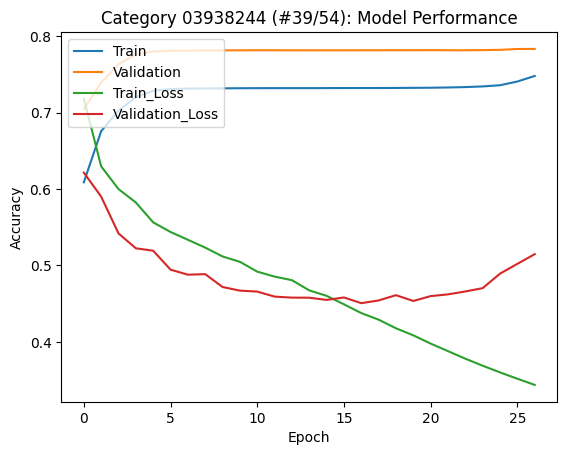

Starting training model for category #40/54: 03948459
x_train shape: (245, 128, 128, 1)
x_test shape: (62, 128, 128, 1)
y_train shape: (245, 32, 32, 32, 1)
y_test shape: (62, 32, 32, 32, 1)
Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.6319
Epoch 1: val_accuracy improved from -inf to 0.74367, saving model to models/1x128x32\03948459.keras
7/7 [==============================] - 24s 4s/step - loss: 0.6376 - accuracy: 0.6319 - val_loss: 0.4942 - val_accuracy: 0.7437
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.4681 - accuracy: 0.7286
Epoch 2: val_accuracy improved from 0.74367 to 0.74491, saving model to models/1x128x32\03948459.keras
7/7 [==============================] - 20s 3s/step - loss: 0.4681 - accuracy: 0.7286 - val_loss: 0.4692 - val_accuracy: 0.7449
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.7291
Epoch 3: val_accuracy improved from 0.74491 to 0.74518, saving model to mo

INFO:tensorflow:Assets written to: ram://f2de3759-ba75-4ef7-8dc9-8f866c365002/assets


INFO:tensorflow:Assets written to: ram://f2de3759-ba75-4ef7-8dc9-8f866c365002/assets


Evaluating best model on category 03948459, input: 128, output: 32.
2/2 [==============================] - 1s 466ms/step - loss: 0.3825 - accuracy: 0.8174
Test Loss: 0.3824962079524994, Test Accuracy: 0.8174034953117371


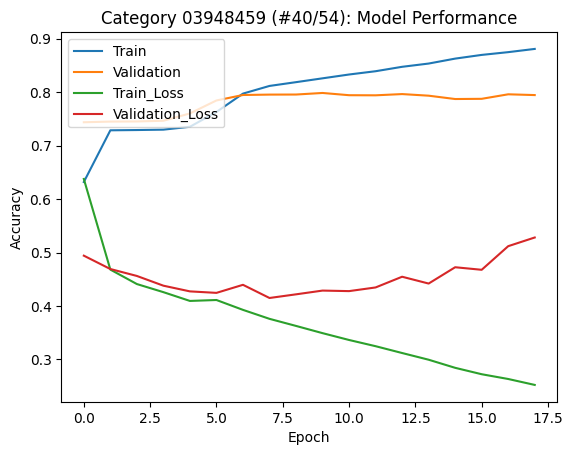

Starting training model for category #41/54: 03991062
x_train shape: (481, 128, 128, 1)
x_test shape: (121, 128, 128, 1)
y_train shape: (481, 32, 32, 32, 1)
y_test shape: (121, 32, 32, 32, 1)
Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.6438 - accuracy: 0.7050
Epoch 1: val_accuracy improved from -inf to 0.78449, saving model to models/1x128x32\03991062.keras
12/12 [==============================] - 24s 2s/step - loss: 0.6438 - accuracy: 0.7050 - val_loss: 0.5450 - val_accuracy: 0.7845
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.4977 - accuracy: 0.7874
Epoch 2: val_accuracy improved from 0.78449 to 0.78604, saving model to models/1x128x32\03991062.keras
12/12 [==============================] - 25s 2s/step - loss: 0.4977 - accuracy: 0.7874 - val_loss: 0.4708 - val_accuracy: 0.7860
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.4460 - accuracy: 0.7876
Epoch 3: val_accuracy did not improve from 0.78604
12/12 [====

INFO:tensorflow:Assets written to: ram://e267e022-b837-43e5-bdef-b5dfb1890d43/assets


INFO:tensorflow:Assets written to: ram://e267e022-b837-43e5-bdef-b5dfb1890d43/assets


Evaluating best model on category 03991062, input: 128, output: 32.
4/4 [==============================] - 2s 460ms/step - loss: 0.5251 - accuracy: 0.7991
Test Loss: 0.5250768065452576, Test Accuracy: 0.799118161201477


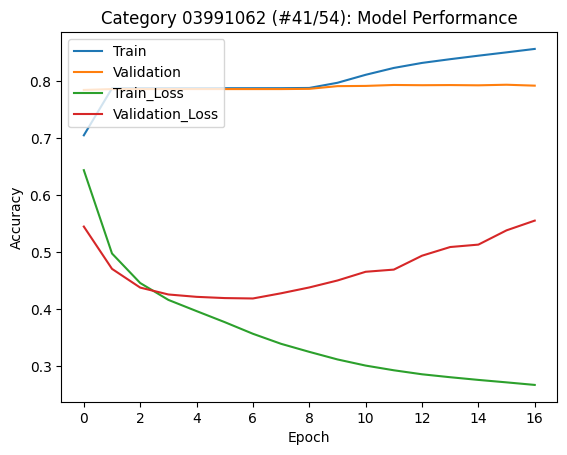

Starting training model for category #42/54: 04004475
x_train shape: (132, 128, 128, 1)
x_test shape: (34, 128, 128, 1)
y_train shape: (132, 32, 32, 32, 1)
y_test shape: (34, 32, 32, 32, 1)
Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.5269
Epoch 1: val_accuracy improved from -inf to 0.71197, saving model to models/1x128x32\04004475.keras
4/4 [==============================] - 25s 8s/step - loss: 0.6974 - accuracy: 0.5269 - val_loss: 0.6424 - val_accuracy: 0.7120
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.7332
Epoch 2: val_accuracy improved from 0.71197 to 0.76233, saving model to models/1x128x32\04004475.keras
4/4 [==============================] - 22s 7s/step - loss: 0.6131 - accuracy: 0.7332 - val_loss: 0.5623 - val_accuracy: 0.7623
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 0.5531 - accuracy: 0.7566
Epoch 3: val_accuracy improved from 0.76233 to 0.76405, saving model to mo

INFO:tensorflow:Assets written to: ram://ef8a9ef0-9def-4709-a3d2-529ebd6afe84/assets


INFO:tensorflow:Assets written to: ram://ef8a9ef0-9def-4709-a3d2-529ebd6afe84/assets


Evaluating best model on category 04004475, input: 128, output: 32.
2/2 [==============================] - 1s 120ms/step - loss: 0.5519 - accuracy: 0.7653
Test Loss: 0.5518568754196167, Test Accuracy: 0.765277624130249


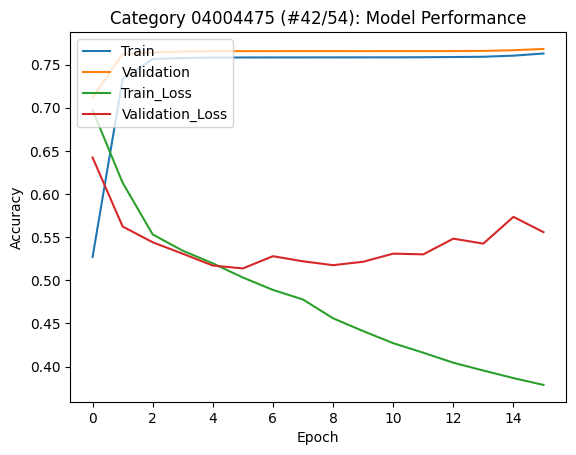

Starting training model for category #43/54: 04074963
x_train shape: (52, 128, 128, 1)
x_test shape: (14, 128, 128, 1)
y_train shape: (52, 32, 32, 32, 1)
y_test shape: (14, 32, 32, 32, 1)
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.4978
Epoch 1: val_accuracy improved from -inf to 0.54468, saving model to models/1x128x32\04074963.keras
2/2 [==============================] - 22s 22s/step - loss: 0.6942 - accuracy: 0.4978 - val_loss: 0.6878 - val_accuracy: 0.5447
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.5548
Epoch 2: val_accuracy improved from 0.54468 to 0.57389, saving model to models/1x128x32\04074963.keras
2/2 [==============================] - 25s 24s/step - loss: 0.6867 - accuracy: 0.5548 - val_loss: 0.6736 - val_accuracy: 0.5739
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.6679 - accuracy: 0.5973
Epoch 3: val_accuracy improved from 0.57389 to 0.60059, saving model to mo

INFO:tensorflow:Assets written to: ram://af430625-a132-4675-b7f6-094050d8dcf9/assets


INFO:tensorflow:Assets written to: ram://af430625-a132-4675-b7f6-094050d8dcf9/assets


Evaluating best model on category 04074963, input: 128, output: 32.
1/1 [==============================] - 0s 477ms/step - loss: 0.6270 - accuracy: 0.6621
Test Loss: 0.6269553303718567, Test Accuracy: 0.6620963215827942


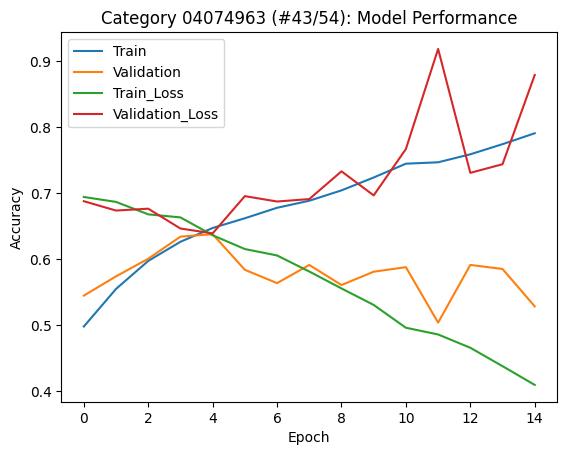

Starting training model for category #44/54: 04090263
x_train shape: (1898, 128, 128, 1)
x_test shape: (475, 128, 128, 1)
y_train shape: (1898, 32, 32, 32, 1)
y_test shape: (475, 32, 32, 32, 1)
Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 0.5191 - accuracy: 0.7337
Epoch 1: val_accuracy improved from -inf to 0.75563, saving model to models/1x128x32\04090263.keras
48/48 [==============================] - 30s 616ms/step - loss: 0.5191 - accuracy: 0.7337 - val_loss: 0.4402 - val_accuracy: 0.7556
Epoch 2/100
48/48 [==============================] - ETA: 0s - loss: 0.4289 - accuracy: 0.7526
Epoch 2: val_accuracy improved from 0.75563 to 0.75621, saving model to models/1x128x32\04090263.keras
48/48 [==============================] - 29s 618ms/step - loss: 0.4289 - accuracy: 0.7526 - val_loss: 0.4180 - val_accuracy: 0.7562
Epoch 3/100
48/48 [==============================] - ETA: 0s - loss: 0.4089 - accuracy: 0.7791
Epoch 3: val_accuracy improved from 0.75621 to 0.80133

INFO:tensorflow:Assets written to: ram://aaf386fc-cfd1-4935-90e1-538cbf99abac/assets


INFO:tensorflow:Assets written to: ram://aaf386fc-cfd1-4935-90e1-538cbf99abac/assets


Evaluating best model on category 04090263, input: 128, output: 32.
15/15 [==============================] - 7s 471ms/step - loss: 0.3854 - accuracy: 0.8228
Test Loss: 0.3853631913661957, Test Accuracy: 0.8227584958076477


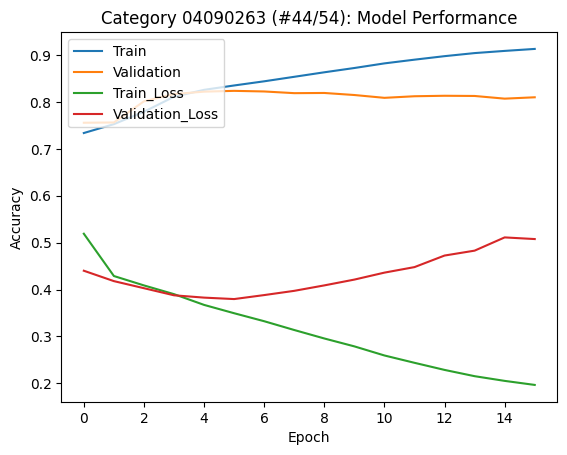

Starting training model for category #45/54: 04099429
x_train shape: (68, 128, 128, 1)
x_test shape: (17, 128, 128, 1)
y_train shape: (68, 32, 32, 32, 1)
y_test shape: (17, 32, 32, 32, 1)
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.4946
Epoch 1: val_accuracy improved from -inf to 0.72865, saving model to models/1x128x32\04099429.keras
2/2 [==============================] - 25s 24s/step - loss: 0.6955 - accuracy: 0.4946 - val_loss: 0.6586 - val_accuracy: 0.7286
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.7071
Epoch 2: val_accuracy improved from 0.72865 to 0.77174, saving model to models/1x128x32\04099429.keras
2/2 [==============================] - 23s 22s/step - loss: 0.6385 - accuracy: 0.7071 - val_loss: 0.5874 - val_accuracy: 0.7717
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.7340
Epoch 3: val_accuracy improved from 0.77174 to 0.77365, saving model to mo

INFO:tensorflow:Assets written to: ram://83d8881e-b117-4c00-9858-2c17b63b88ed/assets


INFO:tensorflow:Assets written to: ram://83d8881e-b117-4c00-9858-2c17b63b88ed/assets


Evaluating best model on category 04099429, input: 128, output: 32.
1/1 [==============================] - 0s 498ms/step - loss: 0.4994 - accuracy: 0.7354
Test Loss: 0.49936357140541077, Test Accuracy: 0.7353677153587341


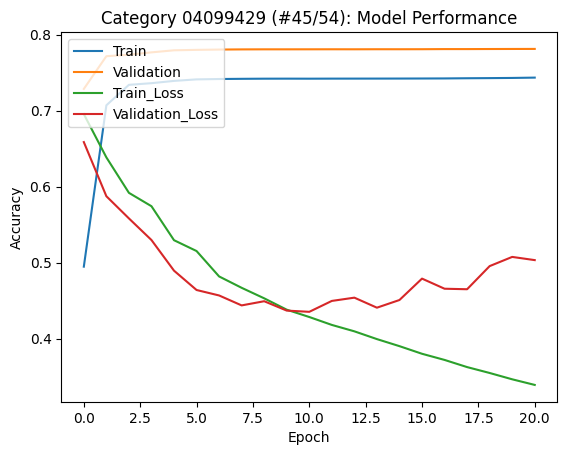

Starting training model for category #46/54: 04225987


ValueError: Found input variables with inconsistent numbers of samples: [115, 152]

In [12]:
train_models_all_categories(categories[38:],
                            input_shape=(128, 128, 1),
                            output_shape=(32, 32, 32, 1),
                            images_per_voxel=1,
                            test_size=0.2,
                            validation_split=0.2,
                            initial_cat_index=38)

Starting training model for category #47/54: 04256520
x_train shape: (2538, 128, 128, 1)
x_test shape: (635, 128, 128, 1)
y_train shape: (2538, 32, 32, 32, 1)
y_test shape: (635, 32, 32, 32, 1)
Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 0.5431 - accuracy: 0.6988
Epoch 1: val_accuracy improved from -inf to 0.70830, saving model to models/1x128x32\04256520.keras
64/64 [==============================] - 35s 492ms/step - loss: 0.5431 - accuracy: 0.6988 - val_loss: 0.5127 - val_accuracy: 0.7083
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.7114
Epoch 2: val_accuracy improved from 0.70830 to 0.72059, saving model to models/1x128x32\04256520.keras
64/64 [==============================] - 30s 465ms/step - loss: 0.5033 - accuracy: 0.7114 - val_loss: 0.4984 - val_accuracy: 0.7206
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 0.4833 - accuracy: 0.7282
Epoch 3: val_accuracy improved from 0.72059 to 0.73074

INFO:tensorflow:Assets written to: ram://a3a80847-16d7-4442-b06f-97ab642abd04/assets


INFO:tensorflow:Assets written to: ram://a3a80847-16d7-4442-b06f-97ab642abd04/assets


Evaluating best model on category 04256520, input: 128, output: 32.
20/20 [==============================] - 10s 479ms/step - loss: 0.4914 - accuracy: 0.7338
Test Loss: 0.49138307571411133, Test Accuracy: 0.7337754368782043


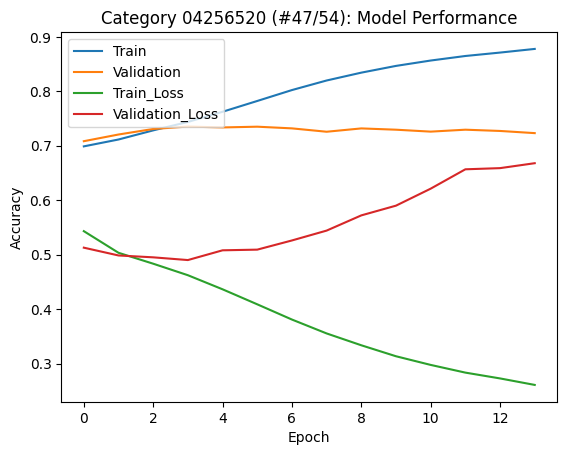

Starting training model for category #48/54: 04330267
x_train shape: (174, 128, 128, 1)
x_test shape: (44, 128, 128, 1)
y_train shape: (174, 32, 32, 32, 1)
y_test shape: (44, 32, 32, 32, 1)
Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.6456 - accuracy: 0.6390
Epoch 1: val_accuracy improved from -inf to 0.69447, saving model to models/1x128x32\04330267.keras
5/5 [==============================] - 25s 6s/step - loss: 0.6456 - accuracy: 0.6390 - val_loss: 0.5991 - val_accuracy: 0.6945
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.5783 - accuracy: 0.7189
Epoch 2: val_accuracy improved from 0.69447 to 0.69489, saving model to models/1x128x32\04330267.keras
5/5 [==============================] - 34s 8s/step - loss: 0.5783 - accuracy: 0.7189 - val_loss: 0.6145 - val_accuracy: 0.6949
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.5651 - accuracy: 0.7193
Epoch 3: val_accuracy did not improve from 0.69489
5/5 [==================

INFO:tensorflow:Assets written to: ram://023d5a34-5db1-48cb-b81d-1252d7136d64/assets


INFO:tensorflow:Assets written to: ram://023d5a34-5db1-48cb-b81d-1252d7136d64/assets


Evaluating best model on category 04330267, input: 128, output: 32.
2/2 [==============================] - 1s 244ms/step - loss: 0.7027 - accuracy: 0.7315
Test Loss: 0.7027026414871216, Test Accuracy: 0.7315313220024109


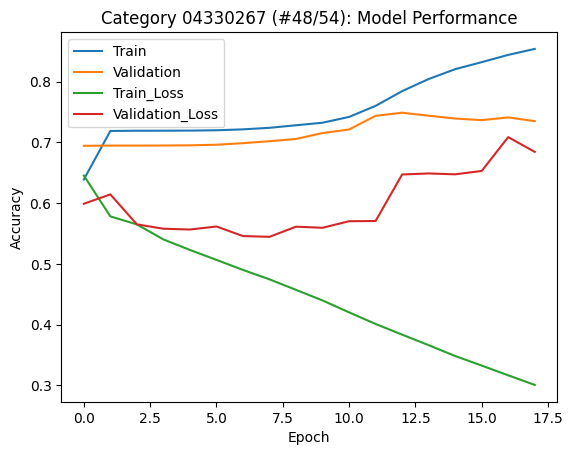

Starting training model for category #49/54: 04379243
x_train shape: (6748, 128, 128, 1)
x_test shape: (1688, 128, 128, 1)
y_train shape: (6748, 32, 32, 32, 1)
y_test shape: (1688, 32, 32, 32, 1)
Epoch 1/100
169/169 [==============================] - ETA: 0s - loss: 0.3691 - accuracy: 0.8339
Epoch 1: val_accuracy improved from -inf to 0.85736, saving model to models/1x128x32\04379243.keras
169/169 [==============================] - 44s 257ms/step - loss: 0.3691 - accuracy: 0.8339 - val_loss: 0.3297 - val_accuracy: 0.8574
Epoch 2/100
169/169 [==============================] - ETA: 0s - loss: 0.3146 - accuracy: 0.8583
Epoch 2: val_accuracy improved from 0.85736 to 0.86184, saving model to models/1x128x32\04379243.keras
169/169 [==============================] - 43s 254ms/step - loss: 0.3146 - accuracy: 0.8583 - val_loss: 0.3068 - val_accuracy: 0.8618
Epoch 3/100
169/169 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.8643
Epoch 3: val_accuracy improved from 0.8618

INFO:tensorflow:Assets written to: ram://169b0eef-c3e1-457a-abd1-61c8acb7c664/assets


INFO:tensorflow:Assets written to: ram://169b0eef-c3e1-457a-abd1-61c8acb7c664/assets


Evaluating best model on category 04379243, input: 128, output: 32.
53/53 [==============================] - 26s 486ms/step - loss: 0.3065 - accuracy: 0.8632
Test Loss: 0.30649080872535706, Test Accuracy: 0.8632092475891113


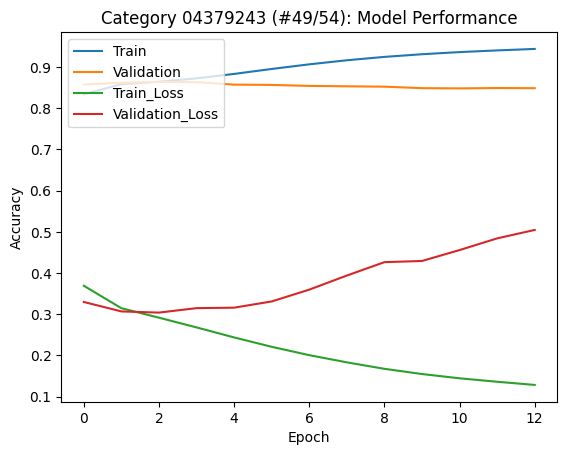

Starting training model for category #50/54: 04401088


ValueError: Found input variables with inconsistent numbers of samples: [53, 1089]

In [14]:
train_models_all_categories(categories[46:],
                            input_shape=(128, 128, 1),
                            output_shape=(32, 32, 32, 1),
                            images_per_voxel=1,
                            test_size=0.2,
                            validation_split=0.2,
                            initial_cat_index=46)

Starting training model for category #53/54: 04530566
x_train shape: (1551, 128, 128, 1)
x_test shape: (388, 128, 128, 1)
y_train shape: (1551, 32, 32, 32, 1)
y_test shape: (388, 32, 32, 32, 1)
Epoch 1/100
39/39 [==============================] - ETA: 0s - loss: 0.5226 - accuracy: 0.7134
Epoch 1: val_accuracy improved from -inf to 0.72909, saving model to models/1x128x32\04530566.keras
39/39 [==============================] - 30s 774ms/step - loss: 0.5226 - accuracy: 0.7134 - val_loss: 0.4694 - val_accuracy: 0.7291
Epoch 2/100
39/39 [==============================] - ETA: 0s - loss: 0.4678 - accuracy: 0.7247
Epoch 2: val_accuracy improved from 0.72909 to 0.74820, saving model to models/1x128x32\04530566.keras
39/39 [==============================] - 28s 724ms/step - loss: 0.4678 - accuracy: 0.7247 - val_loss: 0.4572 - val_accuracy: 0.7482
Epoch 3/100
39/39 [==============================] - ETA: 0s - loss: 0.4500 - accuracy: 0.7466
Epoch 3: val_accuracy improved from 0.74820 to 0.75683

INFO:tensorflow:Assets written to: ram://cdde35f8-7cb3-4bdd-a666-052014fe1906/assets


INFO:tensorflow:Assets written to: ram://cdde35f8-7cb3-4bdd-a666-052014fe1906/assets


Evaluating best model on category 04530566, input: 128, output: 32.
13/13 [==============================] - 6s 468ms/step - loss: 0.4547 - accuracy: 0.7643
Test Loss: 0.45472410321235657, Test Accuracy: 0.764285147190094


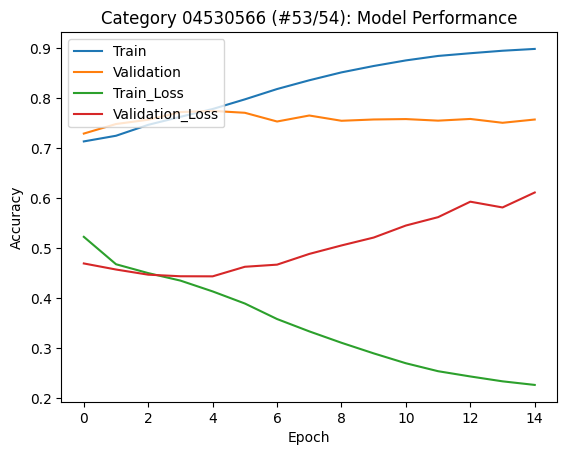

Starting training model for category #54/54: 04554684
x_train shape: (135, 128, 128, 1)
x_test shape: (34, 128, 128, 1)
y_train shape: (135, 32, 32, 32, 1)
y_test shape: (34, 32, 32, 32, 1)
Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.5728
Epoch 1: val_accuracy improved from -inf to 0.71713, saving model to models/1x128x32\04554684.keras
4/4 [==============================] - 26s 8s/step - loss: 0.6855 - accuracy: 0.5728 - val_loss: 0.5719 - val_accuracy: 0.7171
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.7054
Epoch 2: val_accuracy did not improve from 0.71713
4/4 [==============================] - 1s 118ms/step - loss: 0.6042 - accuracy: 0.7054 - val_loss: 0.6092 - val_accuracy: 0.7115
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 0.5894 - accuracy: 0.7044
Epoch 3: val_accuracy improved from 0.71713 to 0.72739, saving model to models/1x128x32\04554684.keras
4/4 [================

INFO:tensorflow:Assets written to: ram://b1e56dc8-851c-4524-a75b-03d7196e13e2/assets


INFO:tensorflow:Assets written to: ram://b1e56dc8-851c-4524-a75b-03d7196e13e2/assets


Evaluating best model on category 04554684, input: 128, output: 32.
2/2 [==============================] - 1s 111ms/step - loss: 0.4736 - accuracy: 0.7922
Test Loss: 0.4736030697822571, Test Accuracy: 0.7922040224075317


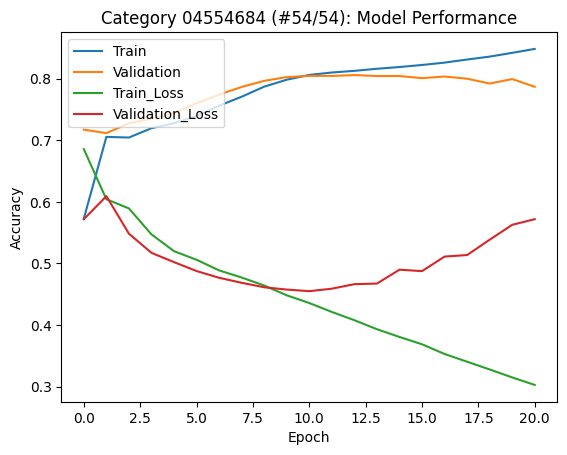

In [18]:
train_models_all_categories(categories[52:],
                            input_shape=(128, 128, 1),
                            output_shape=(32, 32, 32, 1),
                            images_per_voxel=1,
                            test_size=0.2,
                            validation_split=0.2,
                            initial_cat_index=52)

### Discarded categories 47, 50, 51, 52 due to data error

### Part V. Validating Model <a class="anchor" id="#part-5"></a>

In [128]:
# Convert a single testing image into NPY
save_npy_array_from_png(['test1.png'], (128, 128), npy_filename='test_image1')

Starting pipeline...
100.0% (1 files done)

Final NumPy array shape: (1, 128, 128, 1)


In [133]:
# Load the image and reshape adding a batch dimension for prediction
image_npy = np.load('test_image1.npy')
print(image_npy.shape)
image_npy = image_npy.reshape(1, 128, 128, 1)

# Make a Prediction and remove batch channel from prediction
test_model_2 = tf.keras.models.load_model('models/1x128x32/02691156.keras')
predicted_voxel = test_model.predict(image_npy)
predicted_voxel = predicted_voxel[0, :, :, :, 0]

# Convert the voxel grid to a binary format (can modify threshold)
predicted_voxel_binary = (predicted_voxel > 0.5).astype(bool)
print(predicted_voxel_binary.shape)

save_voxel_grid_to_obj(predicted_voxel_binary, "test_voxel2.obj")

(1, 128, 128, 1)
1/1 [==============================] - 0s 21ms/step
(32, 32, 32)


In [22]:
def save_voxel_grid_to_obj(voxel_grid, obj_filename):
    # Vertices and faces for an individual cube (each voxel)
    vertex_offsets = [
        (0, 0, 0), (1, 0, 0), (1, 1, 0), (0, 1, 0),
        (0, 0, 1), (1, 0, 1), (1, 1, 1), (0, 1, 1)
    ]
    
    face_offsets = [
        (0, 1, 2, 3), # Bottom
        (4, 5, 6, 7), # Top
        (0, 1, 5, 4), # Front
        (2, 3, 7, 6), # Back
        (1, 2, 6, 5), # Right
        (3, 0, 4, 7)  # Left
    ]

    vertices = []
    faces = []
    vertex_index = 1

    # Iterate through the 3D array and process each voxel
    for x in range(voxel_grid.shape[0]):
        for y in range(voxel_grid.shape[1]):
            for z in range(voxel_grid.shape[2]):
                if voxel_grid[x, y, z] == 1:  # Only process occupied voxels (value 1)
                    # Add vertices for this voxel's cube
                    for dx, dy, dz in vertex_offsets:
                        vertices.append((x + dx, y + dy, z + dz))

                    # Add faces using the latest 8 vertices
                    for face in face_offsets:
                        faces.append((
                            vertex_index + face[0],
                            vertex_index + face[1],
                            vertex_index + face[2],
                            vertex_index + face[3]
                        ))

                    # Update the vertex index
                    vertex_index += 8

    # Write vertices and faces to an OBJ file
    with open(obj_filename, 'w') as obj_file:
        for vertex in vertices:
            obj_file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")
        for face in faces:
            obj_file.write(f"f {face[0]} {face[1]} {face[2]} {face[3]}\n")


# Save the voxel grid to an OBJ file
save_voxel_grid_to_obj(predicted_voxel_binary, 'test_voxel.obj')

In [66]:
image_npy = np.load('voxels/32/02691156_voxels.npy') # test_image.npy')
image_npy = image_npy[1]
print(image_npy.shape)
image_npy = image_npy[:, :, :, 0]
print(image_npy.shape)
save_voxel_grid_to_obj(image_npy, "test_voxel.obj")

(32, 32, 32, 1)
(32, 32, 32)


In [81]:
images_npy = np.load('images/128/02691156_images.npy') # test_image.npy
image_npy = images_npy[1800:1801, :, :, :]
image_npy_to_png = images_npy[1800, :, :, 0]
npy_to_png(image_npy_to_png, 'npy_image.png')

predicted_voxel = test_model.predict(image_npy)
predicted_voxel = predicted_voxel[0, :, :, :, 0]

# Convert the voxel grid to a binary format (can modify threshold)
predicted_voxel_binary = (predicted_voxel > 0.5).astype(bool)
print(predicted_voxel_binary.shape)

save_voxel_grid_to_obj(predicted_voxel_binary, "test_voxel.obj")

1/1 [==============================] - 0s 24ms/step
(32, 32, 32)


In [80]:
images_npy[1800, :, :, 0]
np.unique(images_npy[1800, :, :, 0])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        66,  68,  69,  70,  73,  74,  75,  77,  79,  81,  82,  83,  84,
        86,  88,  89,  92,  93,  94,  95,  96,  97,  98, 100, 101, 103,
       104, 105, 106, 107, 108, 109, 111, 112, 113, 115, 116, 117, 118,
       119, 120, 123, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 151, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 20

In [79]:
image_npy = np.load('test_image4.npy')
np.unique(image_npy[0, :, :, 0])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [39]:
def npy_to_png(data, png_file, normalize=True):    
    # Ensure the data is binary (0 or 1)
    img = Image.fromarray(data, mode='L')
    img.show(png_file)

In [56]:
# save_npy_array_from_png(['test.png'], (128, 128), save_npy=True, npy_filename='images_test')

images_npy = np.load('test_image4.npy')
print(images_npy.shape)
image_npy = images_npy[0, :, :, 0]
print(image_npy.shape)
npy_to_png(image_npy, 'npy_image.png')

(1, 128, 128, 1)
(128, 128)


In [127]:
from sklearn.model_selection import train_test_split

def split_data(category, input_shape, output_shape, images_per_voxel, test_size):
    # Set strings with the input and output reso for file reading
    input_reso = str(input_shape[0])
    output_reso = str(output_shape[0])
    
    # Load the numpy arrays (input and output)
    images = np.load(f'images/{input_reso}/{category}_images.npy')
    voxels = np.load(f'voxels/{output_reso}/{category}_voxels.npy')

    # Prepare data based on required images per 3D object
    images, voxels = prepare_data_based_on_images_per_voxel(images, voxels, images_per_voxel)

    return images, voxels
    # Split into test and train subsets
    x_train, x_test, y_train, y_test = train_test_split(images, voxels, test_size=test_size)

    #TODO: DELETE THIS CODE, JUST TESTING
    perc = 0.3
    l_train, l_test = len(x_train), len(x_test)
    s_train, s_test = int(l_train * perc), int(l_test * perc)
    x_train, x_test, y_train, y_test = x_train[:s_train], x_test[:s_test], y_train[:s_train], y_test[:s_test]
    
    return x_train, x_test, y_train, y_test

images, voxels = split_data('02691156', input_shape=(128, 128, 1), output_shape=(32, 32, 32, 1), images_per_voxel=1, test_size=0.3)
images.shape, voxels.shape

((4045, 128, 128, 1), (4045, 32, 32, 32, 1))

In [139]:
image_npy = images[4032, :, :, 0]
print(image_npy.shape)
npy_to_png(image_npy, 'npy_image.png')
save_voxel_grid_to_obj(voxels[4032, :, :, :, 0], "test_voxel.obj")

(128, 128)
